# CellScatter FormFactor to TotalDensity model training walkthrough

In this notebook, we will go through the required preprocessing of data and the utilization of this data for training a deep learning model for predicting TotalDensity plots using FormFactors. Be aware that this notebook was created in a high-performance computing environment using a single NVIDIA P100 GPU with 12GB of RAM, so trying to train these models using the same codes will take at least three times more time in a regular desktop using a CPU. It is recommended to create a Python virtual environment and pip install Numpy, pandas, Tensorflow, scikit-learn, Keras, Matplotlib, Scipy, and statistics. When these are ready, just run the block below to load the required imports. If this creates errors, check the packages using pip list and google the pip packages using the import names.

In [2]:
import random
import math
import time
import collections
from collections import Counter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statistics as st

from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

Here we load the available simulation FormFactor and TotalDensity data into pandas dataframes, after which we transpose them for easier manipulation.

In [4]:
sim_FF_df = pd.read_csv('..\\Used data\\form_factors.csv')
sim_TD_x_df = pd.read_csv('..\\Used data\\gpr_total_density_x_200.csv')
sim_TD_y_df = pd.read_csv('..\\Used data\\gpr_total_density_y_200.csv')

sim_FF_df = sim_FF_df.transpose()
sim_TD_x_df = sim_TD_x_df.transpose()
sim_TD_y_df = sim_TD_y_df.transpose()

If you want to check the data, pandas offers an easy way to visualize the data frame by simply calling its name in a code block.

In [3]:
sim_FF_df

0          1          2          3          4          5    \
0    158.700313  23.453699  71.950184  41.881901  26.452318  11.047131   
1    158.640037  23.425170  71.915288  41.858587  26.419103  11.022817   
2    158.459238  23.339597  71.810614  41.788653  26.319475  10.949886   
3    158.158008  23.197017  71.636207  41.672126  26.153484  10.828371   
4    157.736499  22.997497  71.392140  41.509050  25.921215  10.658322   
..          ...        ...        ...        ...        ...        ...   
995   17.310329   3.131684   1.627084   1.268836   6.549238   0.638636   
996   17.359571   3.161219   1.696287   1.293176   6.484021   0.574354   
997   17.403357   3.190445   1.765104   1.317745   6.417372   0.510177   
998   17.441690   3.219298   1.833502   1.342507   6.349330   0.446154   
999   17.474578   3.247715   1.901452   1.367426   6.279934   0.382344   

           6          7          8          9    ...        603        604  \
0    44.099359  32.289559  35.088986  68.905183  ...  30.323867  39.633213   
1    44.122664  32.258483  35.045804  68.876884  ...  30.286651  39.617226   
2    44.192567  32.165269  34.916287  68.791997  ...  30.175019  39.569268   
3    44.309036  32.009958  34.700512  68.650555  ...  29.989024  39.489352   
4    44.472015  31.792620  34.398613  68.452611  ...  29.728750  39.377495   
..         ...        ...        ...        ...  ...        ...        ...   
995   5.765008   8.441597  13.180741   0.440554  ...   2.535038   7.959169   
996   5.846652   8.470322  12.958096   0.420413  ...   2.529914   7.882230   
997   5.926353   8.496613  12.733305   0.400530  ...   2.528256   7.804138   
998   6.004078   8.520465  12.506490   0.381014  ...   2.529921   7.724918   
999   6.079798   8.541871  12.277769   0.361993  ...   2.534755   7.644597   

           605        606        607         608        609        610  \
0    15.273621  62.063384  36.709497  120.551176  23.179887  22.873782   
1    15.246616  62.023428  36.673243  120.504543  23.152669  22.847299   
2    15.165614  61.903579  36.564501  120.364663  23.071029  22.767861   
3    15.030651  61.703902  36.383333  120.131606  22.935006  22.635501   
4    14.841788  61.424503  36.129841  119.805483  22.744663  22.450279   
..         ...        ...        ...         ...        ...        ...   
995   0.784373   1.926625   3.712288    2.097589  10.944315   2.326322   
996   0.806052   1.846028   3.648188    2.114517  10.943840   2.339834   
997   0.827463   1.768341   3.585205    2.130676  10.938560   2.355930   
998   0.848597   1.693578   3.523357    2.146066  10.928482   2.374578   
999   0.869448   1.621749   3.462664    2.160684  10.913615   2.395735   

           611        612  
0    77.699142  46.556570  
1    77.662203  46.532400  
2    77.551407  46.459897  
3    77.366811  46.339087  
4    77.108512  46.170013  
..         ...        ...  
995   0.094115   4.287337  
996   0.095271   4.316069  
997   0.096396   4.342577  
998   0.097494   4.366867  
999   0.098564   4.388946  

[1000 rows x 613 columns]

In [4]:
sim_TD_x_df

0         1         2         3         4         5         6    \
0   -4.006749 -4.188136 -3.638160 -3.894873 -3.844019 -3.809503 -3.165183   
1   -3.966481 -4.146044 -3.601596 -3.855728 -3.805385 -3.771216 -3.133372   
2   -3.926212 -4.103952 -3.565031 -3.816584 -3.766752 -3.732930 -3.101561   
3   -3.885943 -4.061860 -3.528467 -3.777440 -3.728119 -3.694643 -3.069750   
4   -3.845674 -4.019768 -3.491902 -3.738295 -3.689485 -3.656357 -3.037939   
..        ...       ...       ...       ...       ...       ...       ...   
195  3.845674  4.019768  3.491902  3.738295  3.689485  3.656357  3.037939   
196  3.885943  4.061860  3.528467  3.777440  3.728119  3.694643  3.069750   
197  3.926212  4.103952  3.565031  3.816584  3.766752  3.732930  3.101561   
198  3.966481  4.146044  3.601596  3.855728  3.805385  3.771216  3.133372   
199  4.006749  4.188136  3.638160  3.894873  3.844019  3.809503  3.165183   

          7         8         9    ...       603       604       605  \
0   -3.245228 -4.062528 -3.633562  ... -3.877194 -2.436400 -4.331613   
1   -3.212612 -4.021698 -3.597043  ... -3.838227 -2.411913 -4.288079   
2   -3.179997 -3.980869 -3.560525  ... -3.799260 -2.387427 -4.244546   
3   -3.147382 -3.940039 -3.524007  ... -3.760293 -2.362941 -4.201012   
4   -3.114766 -3.899210 -3.487489  ... -3.721327 -2.338454 -4.157478   
..        ...       ...       ...  ...       ...       ...       ...   
195  3.114766  3.899210  3.487489  ...  3.721327  2.338454  4.157478   
196  3.147382  3.940039  3.524007  ...  3.760293  2.362941  4.201012   
197  3.179997  3.980869  3.560525  ...  3.799260  2.387427  4.244546   
198  3.212612  4.021698  3.597043  ...  3.838227  2.411913  4.288079   
199  3.245228  4.062528  3.633562  ...  3.877194  2.436400  4.331613   

          606       607       608       609       610       611       612  
0   -4.054178 -5.556947 -4.426408 -3.773735 -4.070915 -4.221646 -3.532301  
1   -4.013432 -5.501099 -4.381922 -3.735808 -4.030001 -4.179217 -3.496800  
2   -3.972687 -5.445250 -4.337435 -3.697881 -3.989087 -4.136789 -3.461300  
3   -3.931941 -5.389401 -4.292949 -3.659954 -3.948174 -4.094360 -3.425799  
4   -3.891196 -5.333552 -4.248462 -3.622027 -3.907260 -4.051931 -3.390299  
..        ...       ...       ...       ...       ...       ...       ...  
195  3.891196  5.333552  4.248462  3.622027  3.907260  4.051931  3.390299  
196  3.931941  5.389401  4.292949  3.659954  3.948174  4.094360  3.425799  
197  3.972687  5.445250  4.337435  3.697881  3.989087  4.136789  3.461300  
198  4.013432  5.501099  4.381922  3.735808  4.030001  4.179217  3.496800  
199  4.054178  5.556947  4.426408  3.773735  4.070915  4.221646  3.532301  

[200 rows x 613 columns]

In [5]:
sim_TD_x_df

0         1         2         3         4         5         6    \
0   -4.006749 -4.188136 -3.638160 -3.894873 -3.844019 -3.809503 -3.165183   
1   -3.966481 -4.146044 -3.601596 -3.855728 -3.805385 -3.771216 -3.133372   
2   -3.926212 -4.103952 -3.565031 -3.816584 -3.766752 -3.732930 -3.101561   
3   -3.885943 -4.061860 -3.528467 -3.777440 -3.728119 -3.694643 -3.069750   
4   -3.845674 -4.019768 -3.491902 -3.738295 -3.689485 -3.656357 -3.037939   
..        ...       ...       ...       ...       ...       ...       ...   
195  3.845674  4.019768  3.491902  3.738295  3.689485  3.656357  3.037939   
196  3.885943  4.061860  3.528467  3.777440  3.728119  3.694643  3.069750   
197  3.926212  4.103952  3.565031  3.816584  3.766752  3.732930  3.101561   
198  3.966481  4.146044  3.601596  3.855728  3.805385  3.771216  3.133372   
199  4.006749  4.188136  3.638160  3.894873  3.844019  3.809503  3.165183   

          7         8         9    ...       603       604       605  \
0   -3.245228 -4.062528 -3.633562  ... -3.877194 -2.436400 -4.331613   
1   -3.212612 -4.021698 -3.597043  ... -3.838227 -2.411913 -4.288079   
2   -3.179997 -3.980869 -3.560525  ... -3.799260 -2.387427 -4.244546   
3   -3.147382 -3.940039 -3.524007  ... -3.760293 -2.362941 -4.201012   
4   -3.114766 -3.899210 -3.487489  ... -3.721327 -2.338454 -4.157478   
..        ...       ...       ...  ...       ...       ...       ...   
195  3.114766  3.899210  3.487489  ...  3.721327  2.338454  4.157478   
196  3.147382  3.940039  3.524007  ...  3.760293  2.362941  4.201012   
197  3.179997  3.980869  3.560525  ...  3.799260  2.387427  4.244546   
198  3.212612  4.021698  3.597043  ...  3.838227  2.411913  4.288079   
199  3.245228  4.062528  3.633562  ...  3.877194  2.436400  4.331613   

          606       607       608       609       610       611       612  
0   -4.054178 -5.556947 -4.426408 -3.773735 -4.070915 -4.221646 -3.532301  
1   -4.013432 -5.501099 -4.381922 -3.735808 -4.030001 -4.179217 -3.496800  
2   -3.972687 -5.445250 -4.337435 -3.697881 -3.989087 -4.136789 -3.461300  
3   -3.931941 -5.389401 -4.292949 -3.659954 -3.948174 -4.094360 -3.425799  
4   -3.891196 -5.333552 -4.248462 -3.622027 -3.907260 -4.051931 -3.390299  
..        ...       ...       ...       ...       ...       ...       ...  
195  3.891196  5.333552  4.248462  3.622027  3.907260  4.051931  3.390299  
196  3.931941  5.389401  4.292949  3.659954  3.948174  4.094360  3.425799  
197  3.972687  5.445250  4.337435  3.697881  3.989087  4.136789  3.461300  
198  4.013432  5.501099  4.381922  3.735808  4.030001  4.179217  3.496800  
199  4.054178  5.556947  4.426408  3.773735  4.070915  4.221646  3.532301  

[200 rows x 613 columns]

In [6]:
sim_TD_y_df

0           1           2           3           4           5    \
0    333.204244  334.485664  340.298044  334.684611  332.848038  336.100431   
1    333.566343  334.232327  340.249833  334.350987  333.289027  335.519065   
2    333.731060  333.956931  340.185331  334.168397  333.446321  335.208764   
3    333.822123  333.782696  340.138090  334.099749  333.444878  335.105242   
4    333.888462  333.739810  340.116558  334.106518  333.372566  335.141254   
..          ...         ...         ...         ...         ...         ...   
195  333.778670  333.763426  340.186997  334.106887  333.289838  334.898850   
196  333.729730  333.840736  340.251529  334.089817  333.339024  334.943515   
197  333.669431  333.876643  340.287847  334.036981  333.398144  335.151591   
198  333.544270  333.788974  340.219963  333.938143  333.428262  335.595932   
199  333.251301  333.456646  339.930495  333.779761  333.355737  336.353167   

            6           7           8           9    ...         603  \
0    351.842860  330.512511  337.266229  332.624183  ...  329.131857   
1    350.935144  330.516524  337.318158  332.727117  ...  329.797640   
2    350.600132  330.427115  337.477778  332.762805  ...  329.878943   
3    350.630093  330.351033  337.613346  332.764355  ...  329.660162   
4    350.836216  330.334379  337.668212  332.753040  ...  329.388288   
..          ...         ...         ...         ...  ...         ...   
195  350.553593  330.263046  337.618389  332.786905  ...  329.196610   
196  350.389940  330.073637  337.514903  332.809683  ...  329.381779   
197  350.177928  329.998734  337.359402  332.809623  ...  329.401901   
198  349.928119  330.150935  337.176497  332.769615  ...  329.039184   
199  349.638268  330.635121  337.022604  332.665597  ...  327.925133   

            604         605         606         607         608         609  \
0    328.493013  338.053097  332.910187  336.384540  330.493742  328.922594   
1    328.747349  338.117668  332.806640  336.822260  330.482033  329.448368   
2    328.742041  338.130676  332.756829  336.838387  330.462405  329.307910   
3    328.538288  338.120790  332.805368  336.754824  330.455435  328.968759   
4    328.196835  338.105252  332.922401  336.719547  330.466258  328.711676   
..          ...         ...         ...         ...         ...         ...   
195  328.563470  338.087262  332.971975  336.809905  330.430037  329.568313   
196  328.876883  338.073907  333.016986  336.999441  330.449168  329.557337   
197  329.035338  338.069590  333.048410  337.091830  330.465254  329.381783   
198  328.946697  338.087988  332.961431  336.840729  330.450025  328.951252   
199  328.494958  338.144468  332.560767  335.898296  330.350842  328.122475   

            610         611         612  
0    330.865940  329.636917  322.430402  
1    331.141939  329.756934  324.831431  
2    331.286935  329.805601  326.176001  
3    331.357395  329.813347  326.721055  
4    331.378835  329.802678  326.715502  
..          ...         ...         ...  
195  331.244414  329.786218  325.799012  
196  330.907225  329.802986  325.998720  
197  330.670172  329.805961  326.142870  
198  330.704654  329.773324  326.133732  
199  331.172101  329.674604  325.845948  

[200 rows x 613 columns]

Now we will randomly divide the available simulation data into training and test data, and then we will scale every case individually using their mean and standard deviation. The training data is set to be 80 % of available data, which means 490 training input-output pairs and 123 test input-output pairs. Individual scaling upholds scale differences while reducing the seen value ranges, making pattern-seeking during training much easier since the neural network only needs to consider an input range of [-1,3] and an output range of [-4,4] instead of an input range of [0,400] and an output range of [150,500].

In [5]:
def simulation_FF_to_TD_preprocessing(sim_FF_df, sim_TD_x_df, sim_TD_y_df):
    random.seed(42)
    train = random.sample(list(sim_FF_df.columns),int(round(613*0.8,0)))
    test = []
    for number in list(sim_FF_df.columns):
        if not number in train:
            test.append(number)
       
    FF_scaled_values = []
    for column in sim_FF_df.columns:
        FF_scaled_values.append((sim_FF_df[column] - sim_FF_df[column].mean()) / sim_FF_df[column].std())
    
    sim_FF_scaled_df = pd.DataFrame(FF_scaled_values)
    sim_FF_scaled_df = sim_FF_scaled_df.transpose()
    sim_FF_scaled_df.columns = sim_FF_df.columns
            
    sim_TD_x_df = sim_TD_x_df
    TD_x_scaled_values = []
    for column in sim_TD_x_df.columns:
        TD_x_scaled_values.append((sim_TD_x_df[column] - sim_TD_x_df[column].mean()) / sim_TD_x_df[column].std())
        
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = sim_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in sim_TD_y_df.columns:
        TD_y_scaled_values.append((sim_TD_y_df[column] - sim_TD_y_df[column].mean()) / sim_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = sim_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
             
    sim_TD_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = sim_FF_scaled_df[train].transpose().astype(np.float32)
    train_output = sim_TD_df[train].transpose().values.astype(np.float32)
    test_input = sim_FF_scaled_df[test].transpose().astype(np.float32)
    test_output = sim_TD_df[test].transpose().values.astype(np.float32)
    
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)

    return train_input, train_output, test_input, test_output 

train_input, train_output, test_input, test_output = simulation_FF_to_TD_preprocessing(sim_FF_df, sim_TD_x_df, sim_TD_y_df)

(490, 1000)
(490, 400)
(123, 1000)
(123, 400)


Using this code block, we can visualize the original and the resulting preprocessing data. As we can see, simulation FormFactors are much more uniform than simulation TotalDensities, which have some outliers. These outliers are kept because we cannot confirm the correct shapes for TotalDensities predicted from experiment FormFactors, so they are used to show how much the model is able to generalize.

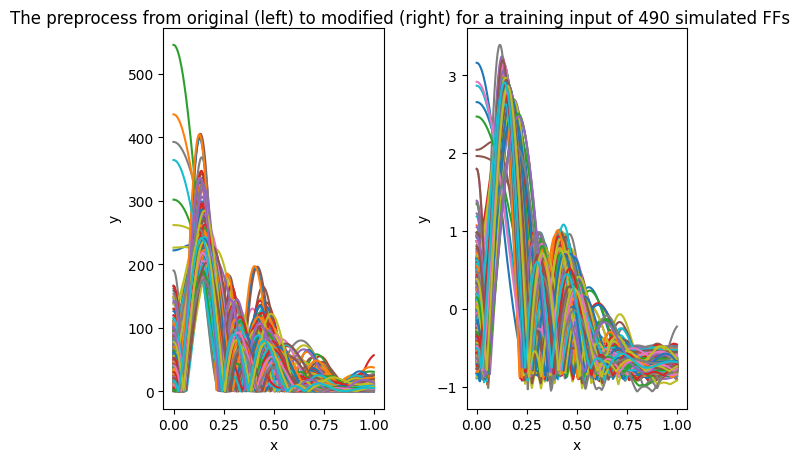

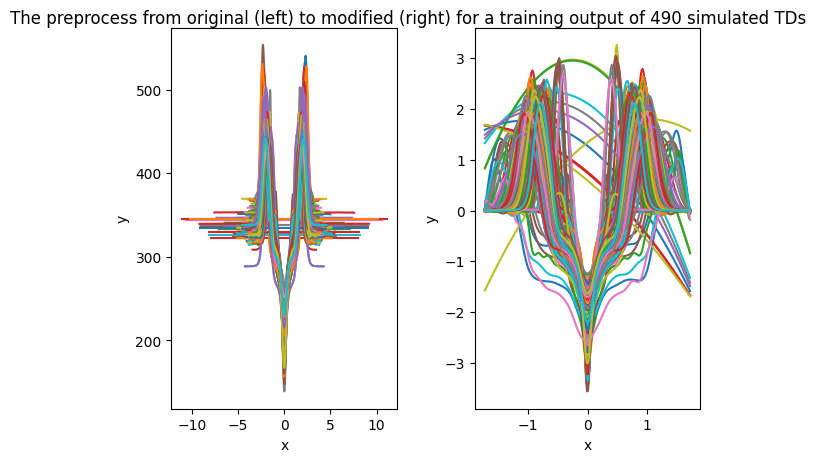

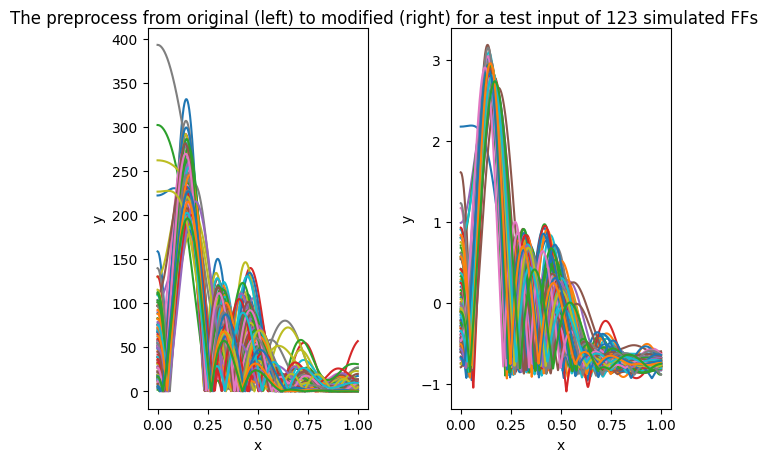

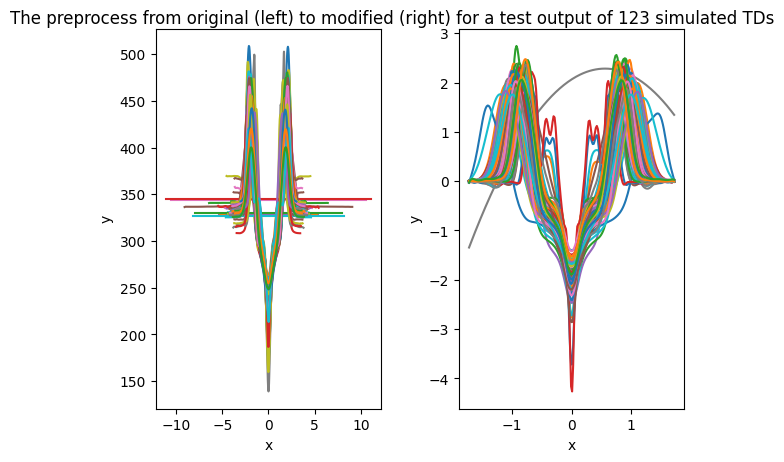

In [6]:
def data_plots(sim_FF_df, sim_TD_x_df, sim_TD_y_df, train_input, train_output, test_input, test_output): 
    
    i = 0
    train_sim_FF_df = pd.DataFrame(train_input)
    columns = train_sim_FF_df.columns
    for row in train_sim_FF_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001),sim_FF_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(np.arange(0,1,0.001),row)
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a training input of ' + str(train_sim_FF_df.shape[0]) + ' simulated FFs')
    plt.show()
    
    i = 0
    train_sim_TD_df = pd.DataFrame(train_output)
    for row in train_sim_TD_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(sim_TD_x_df[i],sim_TD_y_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(row[:200],row[200:])
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a training output of ' + str(train_sim_TD_df.shape[0]) + ' simulated TDs')
    plt.show()
    
    i = 0
    test_sim_FF_df = pd.DataFrame(test_input)
    columns = test_sim_FF_df.columns
    for row in test_sim_FF_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001),sim_FF_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(np.arange(0,1,0.001),row)
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a test input of ' + str(test_sim_FF_df.shape[0]) + ' simulated FFs')
    plt.show()
    
    i = 0
    test_sim_TD_df = pd.DataFrame(test_output)
    for row in test_sim_TD_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(sim_TD_x_df[i],sim_TD_y_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(row[:200],row[200:])
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a test output of ' + str(test_sim_TD_df.shape[0]) + ' simulated TDs')
    plt.show()
    
data_plots(sim_FF_df, sim_TD_x_df, sim_TD_y_df,train_input, train_output, test_input, test_output)

Here are different metrics and plotting functions for analyzing the model's performance. The loss metric is a mean squared error for data points (x,y) because it helps compare the score to the plots. The actual model will not be trained using this kind of loss because it is less efficient and hurts accuracy, so the mean absolute error is used instead.

In [7]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    sorted_loss = np.sort(loss_list)
    loss_quantile_50 = np.percentile(sorted_loss,50)
    loss_quantile_80 = np.percentile(sorted_loss,80)
    loss_quantile_95 = np.percentile(sorted_loss,95)
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for ' + str(amount) + ' cases')
    plt.show()
    
    return [average_loss, mode_loss, median_loss, loss_quantile_50, loss_quantile_80, loss_quantile_95]

def simulation_plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[0]][0:length]
    y_1 = prediction[train[0]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[0]][0:length]
    y_2 = actual[train[0]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[0]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[0]],prediction[train[0]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[4]][0:length]
    y_1 = prediction[train[4]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[4]][0:length]
    y_2 = actual[train[4]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[4]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[4]],prediction[train[4]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[9]][0:length]
    y_1 = prediction[train[9]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[9]][0:length]
    y_2 = actual[train[9]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[9]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[9]],prediction[train[9]])))
    
def experiment_predictions(exp_input,prediction):
    random.seed(42)
    train = random.sample(range(0,len(prediction)),10)
    length = int(len(prediction[0])/2)
    for number in train:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001), exp_input[number])
        plt.subplot(1,2,2)
        plt.plot(prediction[number][0:length],prediction[number][length:])
        plt.suptitle('TD prediction for experiment FF index ' + str(number))
        plt.show()
        
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b')
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction on experiment data')
    plt.show()
    
def predicted_plot(prediction):
    prediction = prediction.reshape(400,1)
    length = int(prediction.shape[0]/2)
    plt.plot(prediction[0:length],prediction[length:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predicted TotalDensity for the given FormFactor')
    plt.show()

Here is a baseline model with appropriate metrics for used time and prediction performance. The idea of all the sequential neural network models in this notebook is to use a given FormFactor y-axis vector with a length of 1000 to predict a vector with a length of 400, where the first 200 values are the x-axis values and the last 200 values are the y-axis values of TotalDensity. This approach was choosen due to straightforwardness and performance, but there might be other valid ways found in machine learning or deep learning for this kind of prediction problem. 

The reason why this approach works is that neural networks learn to notice patterns between input and output data, which are practically represented as the adjusting of weights for the given input values from the previous layer. For example, in this model, the single hidden layer stored in the single x variable adjusts its weights to the input layer values, resulting in output values given to the layer outputs that adjust their weights to produce the desired output. Notice that in a sequential model the amount of layers is arbitrary, which is why the amount of time and the quality of predictions decide an architecture.

Used time: 28.184239864349365 seconds


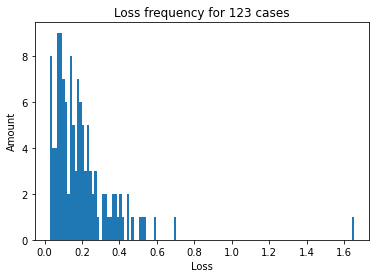

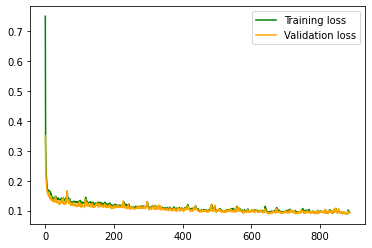

Loss average is: 0.20175488981085374
Loss mode is: [(0.21913, 1), (0.53476, 1), (0.32226, 1), (0.20146, 1), (0.23322, 1), (0.02798, 1), (0.1309, 1), (1.65416, 1), (0.25022, 1), (0.17507, 1)]
Loss median is: 0.15824


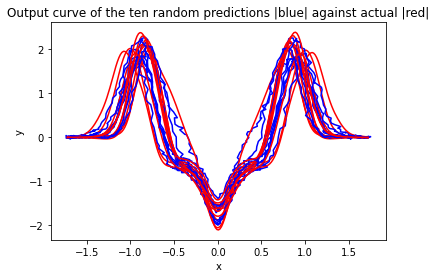

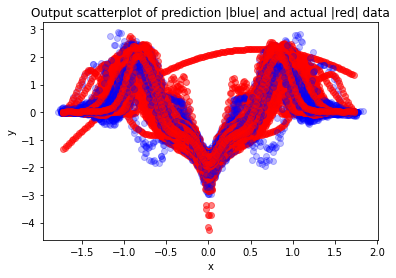

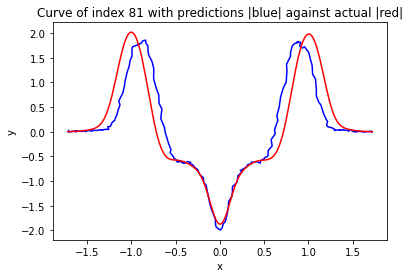

The loss of the curve 0.28492711326453796


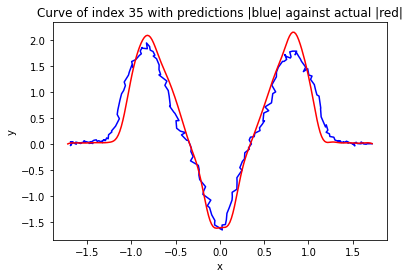

The loss of the curve 0.1707351029896662


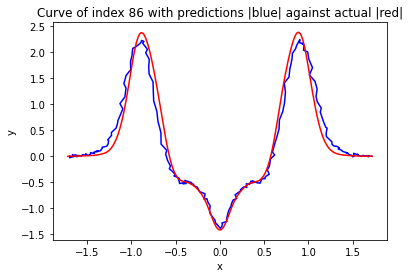

The loss of the curve 0.15824009442002


In [7]:
# Starts clock
general_start_time = time.time()

# Callbacks are separate functions for chancing behavior of training. 
# In this case we only use EarlyStopping, which stops training, when 
# the validation loss doesn't become smaller after 100 epochs.
# Then the best weights from previous epochs are saved into a model
callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

# This defines an Amsgrad variant of the Adam optimizer. Usually some variant 
# of Adam is first used to give an idea for performance, before other optimizers are used  
Adam = tf.keras.optimizers.Adam(amsgrad=True)

# This defines the given input to be a 1000 long vector
inputs = keras.Input(shape=(1000,))

# This defines a regular neural network layer of 1000 neurons using the activation function called reLu.
# ReLu is also usually used to give an idea for perfomrance, before other activation functions are used
x = layers.Dense(1000, activation='relu')(inputs)

# This defines an output layer, which is a regular neural network layer of 400 neurons using the 
# linear activation function, which means all neurons are activated with their weighted outputs.
outputs = layers.Dense(400, activation='linear')(x)

# This defines a model architecture
model = keras.Model(inputs=inputs, outputs=outputs)

# This compiles a model using a Adam optimizer and the intended training loss, which is mean absolute error
# Usually mean squared error is used for regression predictions, but since the output isn't suitable for it
# due to keras loss functions not knowing the division of x-axis and y-axis values, mean absolute error is used
model.compile(optimizer=Adam, loss='mean_absolute_error')

# This used the given training data to traing the model with 
# max 1500 epochs, validation split of 20 % and a training batch size of 128.
# Usually epoch amounts are around 20 to 100, which is why we are giving the model a lot of tries to adjust
# The given batch size divides the available training data of 490 into 128,128,128 and 106 separate batches 
# that are used to train the network. Larger batch sizes make the network converge faster, while smaller batch sizes 
# make the network updates more granural, increasing the used time 
history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

# Ends clock
general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

# Here we used the defined metrics to evaluate predicted TotalDensities against test TotalDensities
results = metrics(test_output, model.predict(test_input))

# These plot the training history of the model
plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))

As we can see from these results, the baseline proves that the model can predict a correct 400 vector with the first 200 x-axis values and the last 200 y-axis values of TotalDensity using the 1000 y-axis vector of FormFactor. However, we are not happy with the baseline because its prediction scatter plot shows bad prediction points, and the curves are not as smooth as we need. A simple way to improve the model could be adding dense layers with different units based on intuitive guesses. Unfortunately, this will give optimal performance only with luck and can take a lot of time.

For these reasons, we will use automatized hyperparameter search of Hyperband using KerasTuner. Hyperband is a good compromise in time and quality because even in an HPC environment, checking every parameter can easily require hours of running. This notebook will only explain how to use Hyperband, but not what it is, so for those interested, it is recommended to use Google or ChatCPT. In practice, the idea is to define a suitable search space for parameters and architecture, after which it is given to a suitable search algorithm. The results are then used to select an architecture.

Trial 90 Complete [00h 00m 21s]
val_loss: 0.12361804395914078

Best val_loss So Far: 0.11131447553634644
Total elapsed time: 00h 09m 22s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 5, 'dense_0_units': 500, 'dropout_0': 0.15000000000000002, 'learning_rate': 0.001, 'dense_1_units': 4000, 'dropout_1': 0.35000000000000003, 'dense_2_units': 2000, 'dropout_2': 0.25, 'dense_3_units': 1000, 'dropout_3': 0.25, 'dense_4_units': 3500, 'dropout_4': 0.25, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               500500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4000)   

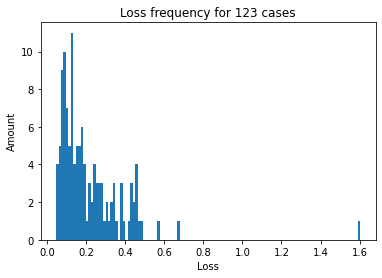

Loss average is: 0.2159077330479292
Loss mode is: [(0.11229, 1), (0.57268, 1), (0.43197, 1), (0.44586, 1), (0.39968, 1), (0.06319, 1), (0.18438, 1), (1.60428, 1), (0.28274, 1), (0.09537, 1)]
Loss median is: 0.16765


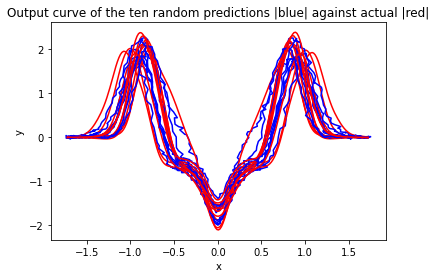

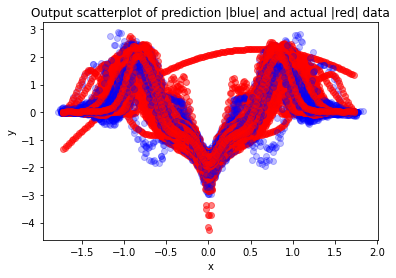

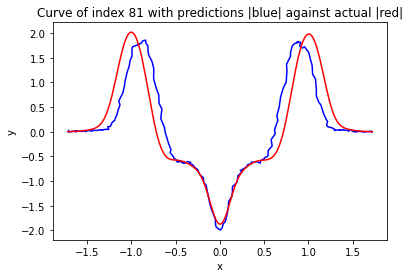

The loss of the curve 0.28492711326453796


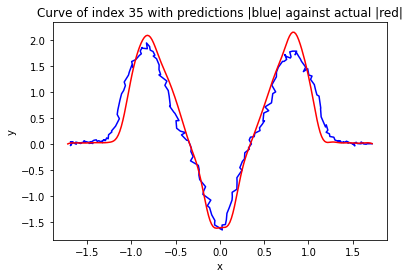

The loss of the curve 0.1707351029896662


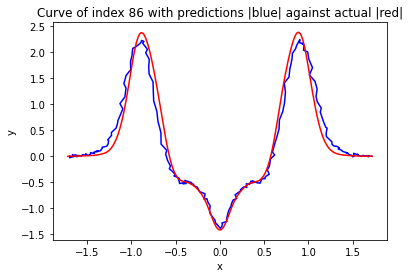

The loss of the curve 0.15824009442002


In [16]:
# This defines the search space in a similar way the previous model was defined
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    # This for loop enables building Dense and Dropout pairs in the architecture
    # Here hp.int is a search space of [1], [1,2],...,[1,2,3,4,5] for the amount of Dense-Dropout pairs
    for i in range(hp.Int('num_layers', 1, 5)):
        # Here hp.Int is used to the define the unit search space of [500,1000,...,3500,4000]
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=4000, step=500), activation='relu'))
        # Dropout handles regularization of the model by ignoring some ratio of the neurons of the previous layer
        # Here hp.Flot is used to define the dropout ratio search space of [0.05,0.10,...,0.45,0.50]
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.50, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    # Here hp.Choice defines the learning rate search space of Adam
    model.compile(optimizer = Adam(amsgrad=True, learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),loss='mean_absolute_error')
    
    return model

# This defines hyperband to minimize validation loss, 
# have max epochs of 30, drop candidates with factor of 3
# and save the model in a folder called my_dir with a name FF_to_TD_1
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    directory='my_dir',
    project_name='FF_to_TD_1')

# This starts the search algorithm, which uses the training data to 
# train each model in 100 epochs base on test validation data
tuner.search(train_input, 
             train_output,
             epochs = 100,
             validation_data=(test_input, test_output))

# This gets the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
# This gets the best architecture summary
two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))

By checking the results, we get the optimized hyperparameters of ['dense_0_units': 500, 'dropout_0': 0.15000000000000002, 'learning_rate': 0.001, 'dense_1_units': 4000, 'dropout_1': 0.35000000000000003, 'dense_2_units': 2000, 'dropout_2': 0.25, 'dense_3_units': 1000, 'dropout_3': 0.25, 'dense_4_units': 3500, 'dropout_4': 0.25]. Notice that even though the predictions are worse than before, this is just the result of training a model with 100 epochs, while previous one was 1500 epochs. Using the given hyperparameters and architecture, we get the following model.

Used time: 92.78813982009888 seconds


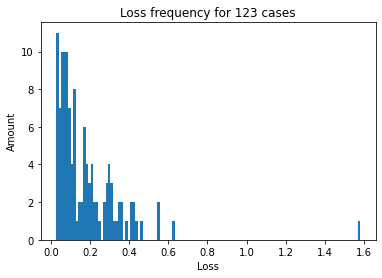

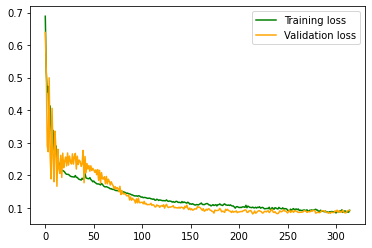

Loss average is: 0.17616863648194425
Loss mode is: [(0.19842, 1), (0.62223, 1), (0.31223, 1), (0.23112, 1), (0.31066, 1), (0.12239, 1), (0.04017, 1), (1.58256, 1), (0.04557, 1), (0.08203, 1)]
Loss median is: 0.11816


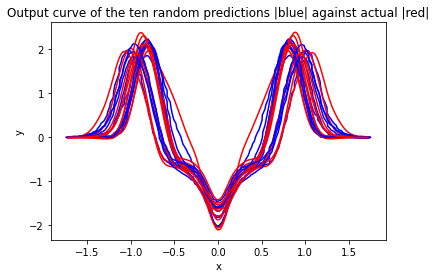

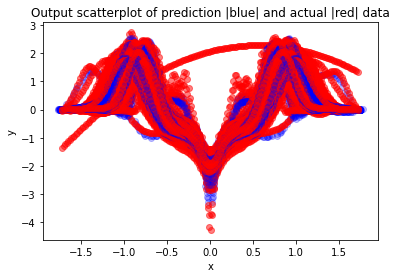

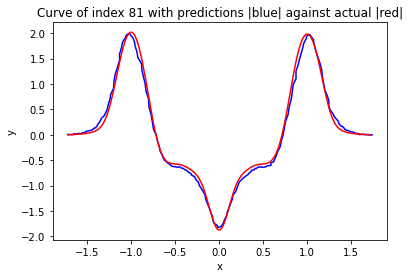

The loss of the curve 0.05276452580611745


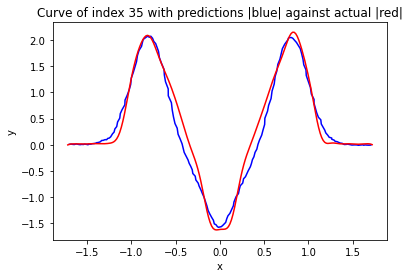

The loss of the curve 0.15042069216653803


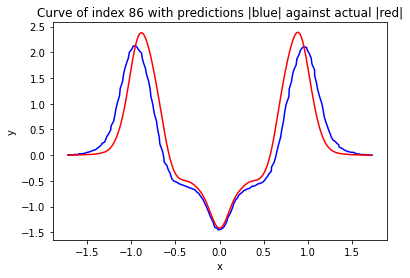

The loss of the curve 0.2530108232539129


In [22]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

optimizer = Adam(learning_rate=0.001, amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(500, activation='relu')(inputs)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.35, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(3500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = optimizer, loss='mean_absolute_error')
# Notice that there batch_size is increased to 200
history = model.fit(train_input, train_output, batch_size=200, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))

Based on the results, we improved the model's loss and made the prediction curves much smoother. However, the MVP model has better results than this, so we are unsatisfied. From here forward, the search process for the better model is pretty much the same, but we now aim to limit the search space by modifying some parameters to get intuitive guesses. If those guesses show that the current model does not show potential, we do a hyperparameter search again with some changes or a smaller search space.

Used time: 137.36046433448792 seconds



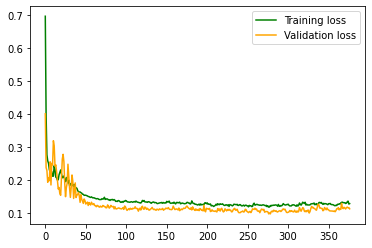

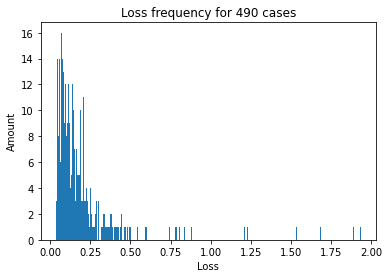

Loss average is: 0.1991922576904887
Loss mode is: [(0.15501, 2), (0.03784, 2), (0.07513, 2), (0.09288, 2), (0.09635, 1), (0.06238, 1), (0.31096, 1), (0.16841, 1), (0.05922, 1), (0.19283, 1)]
Loss median is: 0.140515
Loss 80th quantile: 0.25352625045901456
Loss 95th quantile: 0.5089543310286203


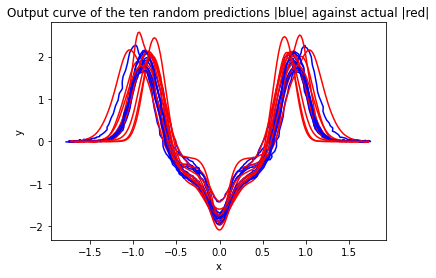

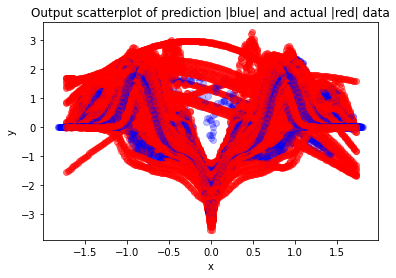

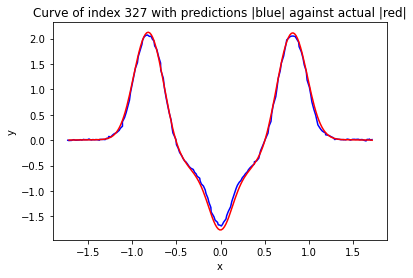

The loss of the curve 0.04889719583565804


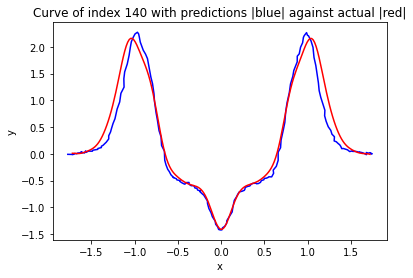

The loss of the curve 0.17145753467762626


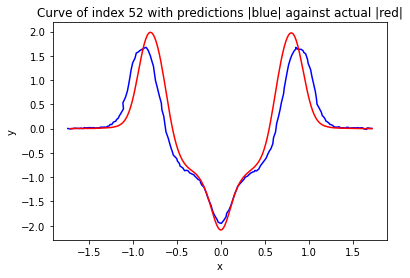

The loss of the curve 0.22614398150525752



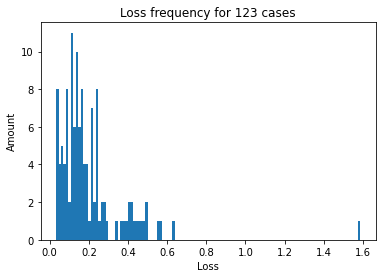

Loss average is: 0.20067570288733325
Loss mode is: [(0.16317, 1), (0.57297, 1), (0.49695, 1), (0.22865, 1), (0.38184, 1), (0.035, 1), (0.15942, 1), (1.58731, 1), (0.27305, 1), (0.11545, 1)]
Loss median is: 0.15383
Loss 80th quantile: 0.2472131982018668
Loss 95th quantile: 0.4844208818353509


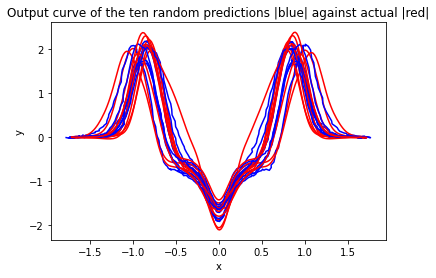

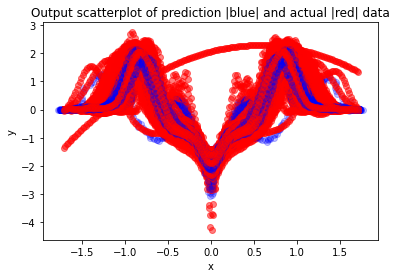

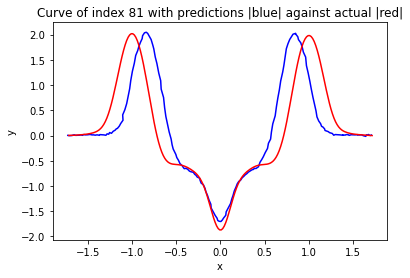

The loss of the curve 0.42514542884382295


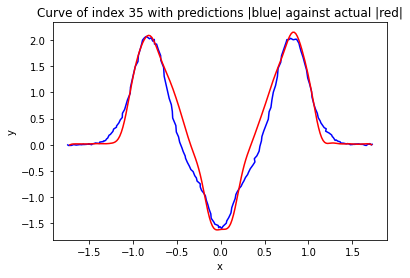

The loss of the curve 0.15801172294784732


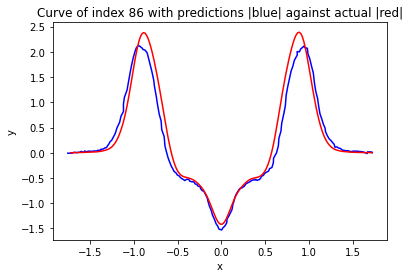

The loss of the curve 0.1259331066362198


In [26]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

optimizer = Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(500, activation='relu')(inputs)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.35, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(3500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = optimizer, loss='mean_absolute_error')
# Notice that we changed back to 128 to compare the model to the baseline
history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Trial 90 Complete [00h 00m 23s]
val_loss: 0.11317655444145203

Best val_loss So Far: 0.10505308210849762
Total elapsed time: 00h 08m 49s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 3, 'dense_0_units': 2500, 'dropout_0': 0.15000000000000002, 'learning_rate': 0.001, 'dense_1_units': 500, 'dropout_1': 0.1, 'dense_2_units': 2000, 'dropout_2': 0.1, 'dense_3_units': 1000, 'dropout_3': 0.2, 'dense_4_units': 1000, 'dropout_4': 0.15000000000000002, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0078'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2500)              2502500   
_________________________________________________________________
dropout (Dropout)            (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)     

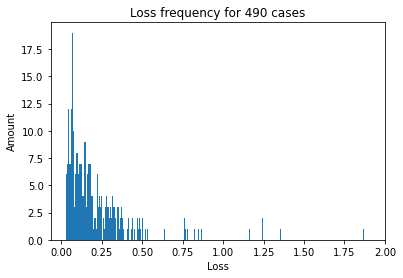

Loss average is: 0.20870216164957114
Loss mode is: [(0.04162, 2), (0.09288, 2), (0.05126, 2), (0.12542, 1), (0.09097, 1), (0.33294, 1), (0.15125, 1), (0.0318, 1), (0.16527, 1), (0.06928, 1)]
Loss median is: 0.147525
Loss 80th quantile: 0.2800217303355767
Loss 95th quantile: 0.512374808463214


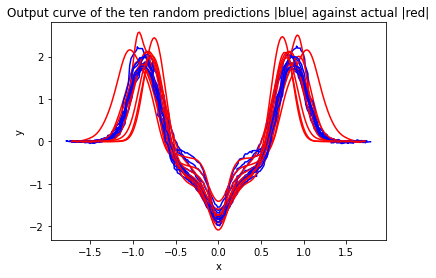

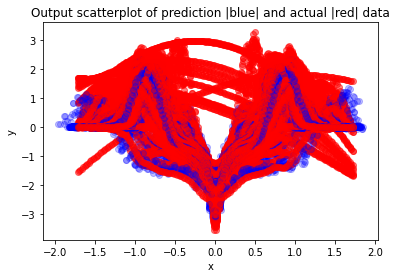

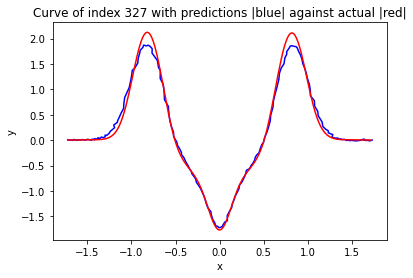

The loss of the curve 0.06775870480602297


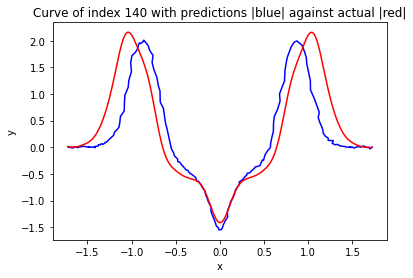

The loss of the curve 0.384730456560986


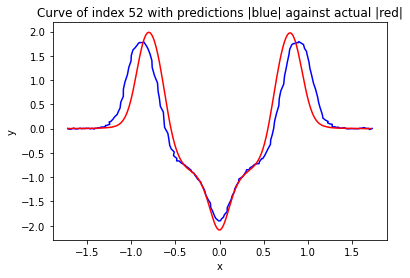

The loss of the curve 0.22767875990976813

Test data score


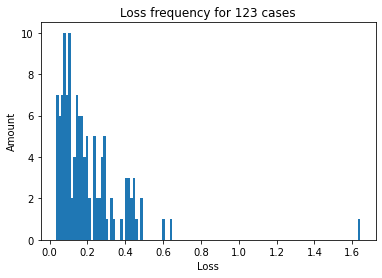

Loss average is: 0.20317050320720303
Loss mode is: [(0.19985, 1), (0.60124, 1), (0.40215, 1), (0.42147, 1), (0.42326, 1), (0.03996, 1), (0.18341, 1), (1.64365, 1), (0.25075, 1), (0.08945, 1)]
Loss median is: 0.15728
Loss 80th quantile: 0.28957358756075186
Loss 95th quantile: 0.4519051053089714


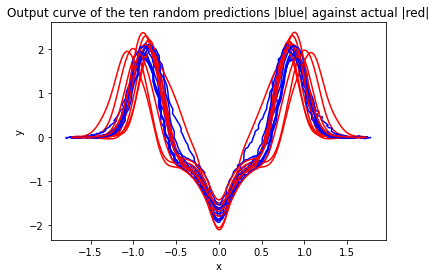

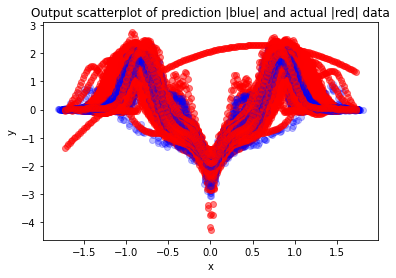

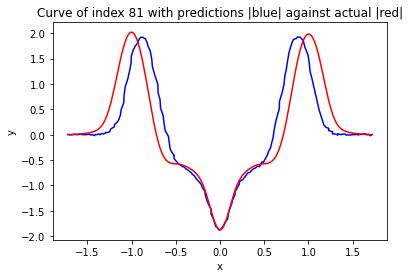

The loss of the curve 0.3283881225379849


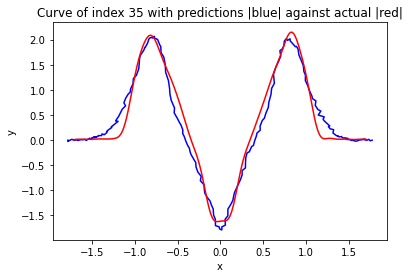

The loss of the curve 0.1572841716637143


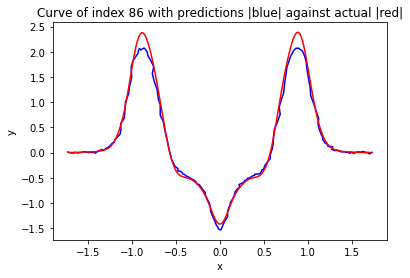

The loss of the curve 0.06608724473744003


In [27]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        # Notice that here unit max_value 3000 and ratio max_value 0.30 are smaller than previous
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=3000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer = Adam(amsgrad=True, learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),loss='mean_absolute_error')
    
    return model

# Notice that here we increased max_epochs
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 40,
    factor = 3,
    directory='my_dir',
    project_name='FF_to_TD_18')

# Notice that here we increased epochs
tuner.search(train_input, 
             train_output,
             epochs = 200,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_models = tuner.get_best_models(num_models=1)
print(best_models[0].summary())

print('')
print('Training data score')

results = metrics(train_output, best_model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output, best_model.predict(train_input))

print('')
print('Test data score')

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output, best_model.predict(test_input))

Used time: 38.399609327316284 seconds



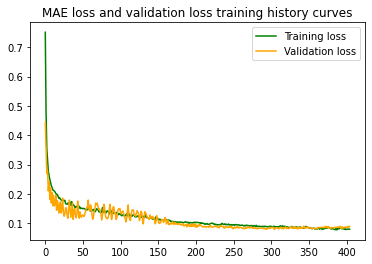


Training data score


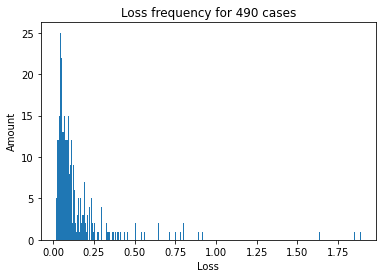

Loss average is: 0.1458576101683056
Loss mode is: [(0.0813, 2), (0.19234, 2), (0.0442, 2), (0.06091, 2), (0.11228, 2), (0.04261, 2), (0.1008, 1), (0.05197, 1), (0.19379, 1), (0.05107, 1)]
Loss median is: 0.084215
Loss 80th quantile: 0.18590868934039798
Loss 95th quantile: 0.4503565048660815


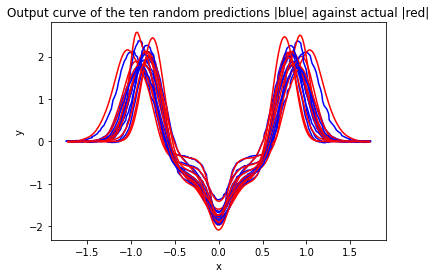

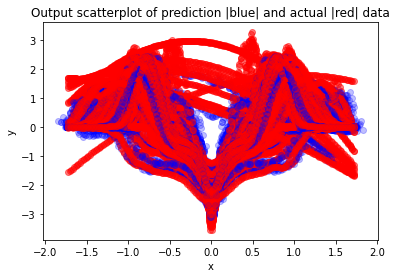

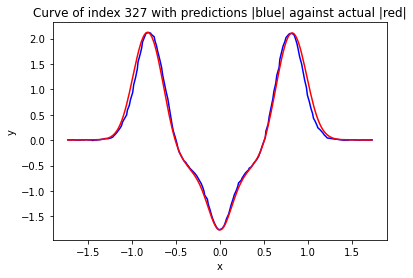

The loss of the curve 0.06480643201699059


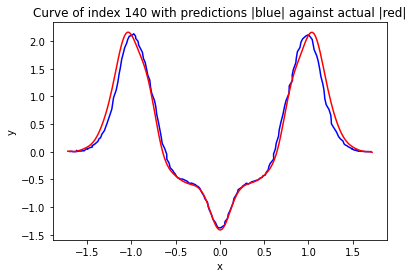

The loss of the curve 0.0831296025915401


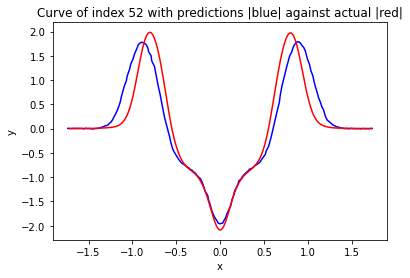

The loss of the curve 0.2208275497319551



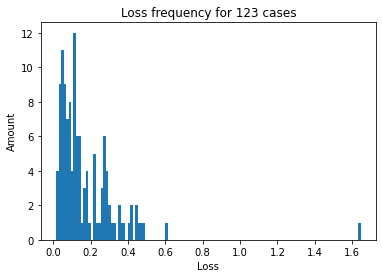

Loss average is: 0.17264192054021116
Loss mode is: [(0.22026, 1), (0.61028, 1), (0.30021, 1), (0.37298, 1), (0.21993, 1), (0.11116, 1), (0.03907, 1), (1.64559, 1), (0.21357, 1), (0.10357, 1)]
Loss median is: 0.11823
Loss 80th quantile: 0.2721857619104803
Loss 95th quantile: 0.4443036709660618


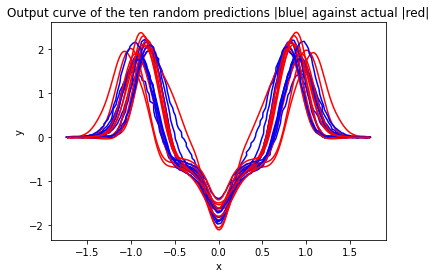

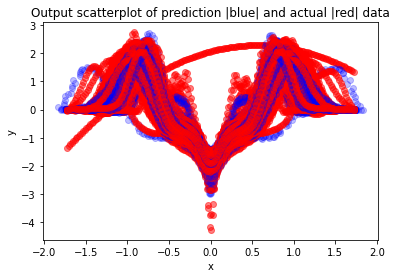

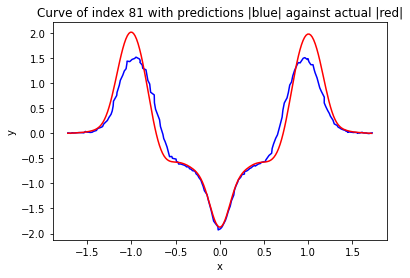

The loss of the curve 0.16873607938119


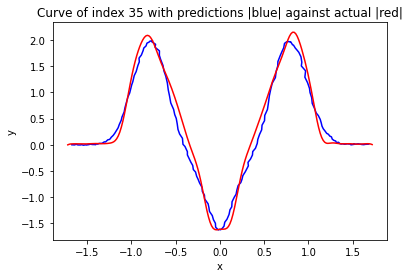

The loss of the curve 0.14905735164574926


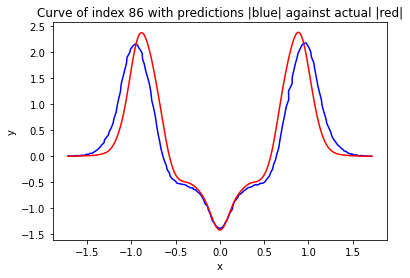

The loss of the curve 0.26839153128867255


In [28]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]
# Notice we now define learning_rate 
optimizer = Adam(amsgrad=True, learning_rate = 0.001)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = optimizer, loss='mean_absolute_error')
# Notice we put batch_size 200 again
history = model.fit(train_input, train_output, batch_size=200, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 82.98778557777405 seconds



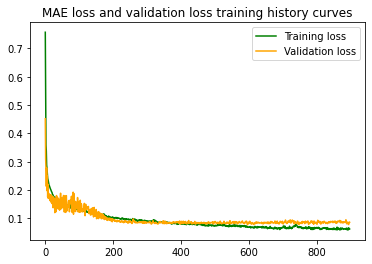


Training data score


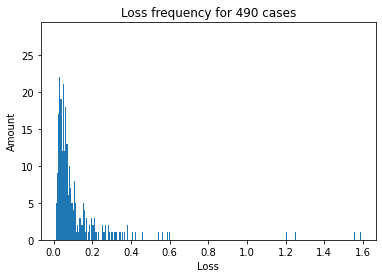

Loss average is: 0.11203492630509414
Loss mode is: [(0.03816, 2), (0.04157, 2), (0.04295, 2), (0.03602, 2), (0.06613, 2), (0.03365, 2), (0.08937, 2), (0.05072, 1), (0.04496, 1), (0.14679, 1)]
Loss median is: 0.062275
Loss 80th quantile: 0.1444926197867532
Loss 95th quantile: 0.34149657630662156


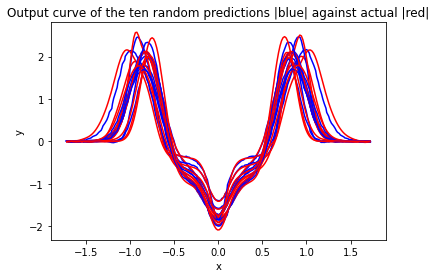

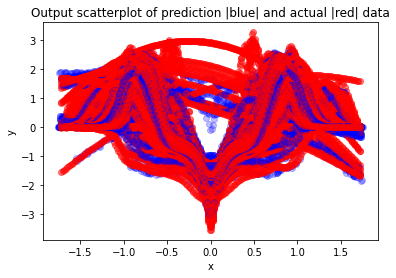

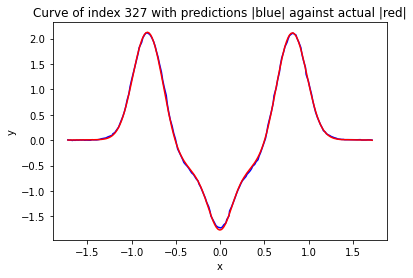

The loss of the curve 0.01595823239885946


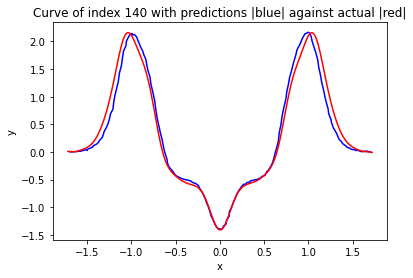

The loss of the curve 0.08104454961155312


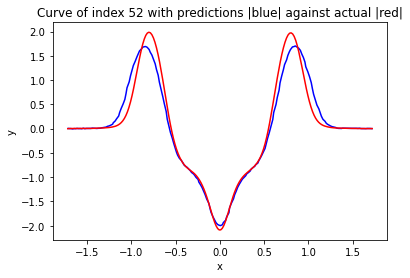

The loss of the curve 0.1364820887886107



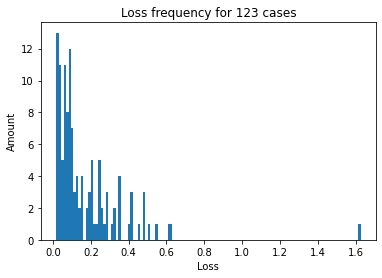

Loss average is: 0.1703482412928802
Loss mode is: [(0.09958, 1), (0.61546, 1), (0.24735, 1), (0.20174, 1), (0.54131, 1), (0.12485, 1), (0.0778, 1), (1.62635, 1), (0.17523, 1), (0.06112, 1)]
Loss median is: 0.09878
Loss 80th quantile: 0.26230367750235906
Loss 95th quantile: 0.48380929320379173


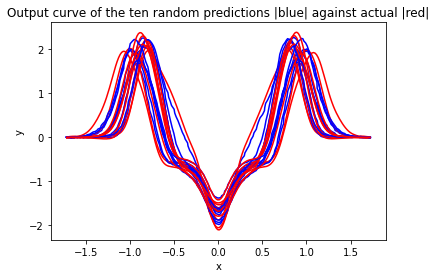

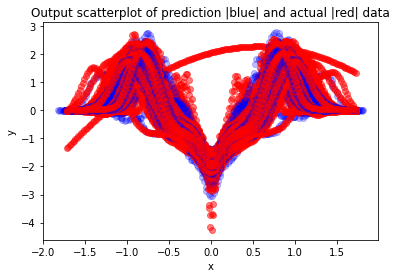

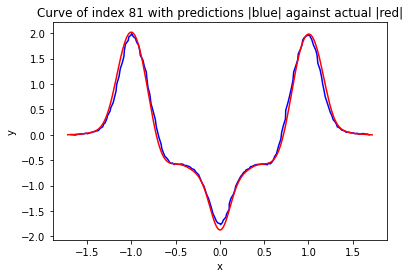

The loss of the curve 0.03949560633869026


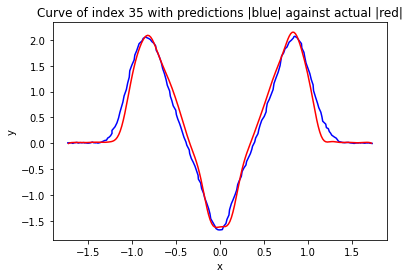

The loss of the curve 0.11098794227004698


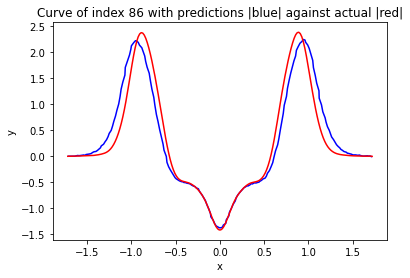

The loss of the curve 0.20391183962395473


In [29]:
general_start_time = time.time()
# Notice we increased patience to 300
callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

optimizer = Adam(amsgrad=True, learning_rate = 0.001)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = optimizer, loss='mean_absolute_error')
# Notice we increased epochs to 2000
history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 67.93638849258423 seconds



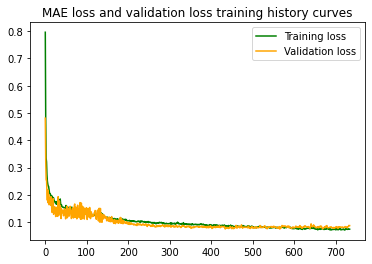


Training data score


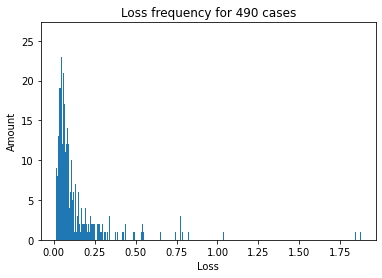

Loss average is: 0.13809824913245403
Loss mode is: [(0.10763, 2), (0.08153, 2), (0.08474, 2), (0.08155, 2), (0.08224, 2), (0.03923, 2), (0.03899, 2), (0.07104, 2), (0.0261, 1), (0.10044, 1)]
Loss median is: 0.07614499999999999
Loss 80th quantile: 0.17041500869213388
Loss 95th quantile: 0.4318895434859062


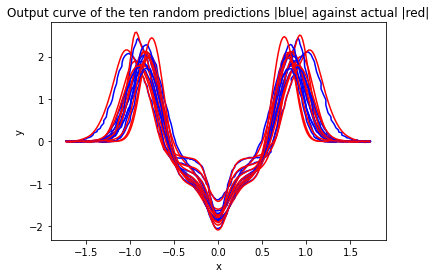

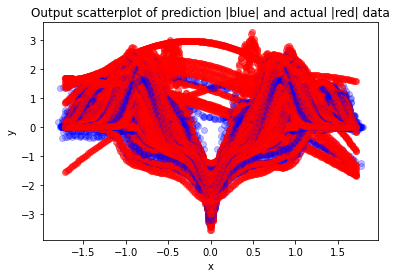

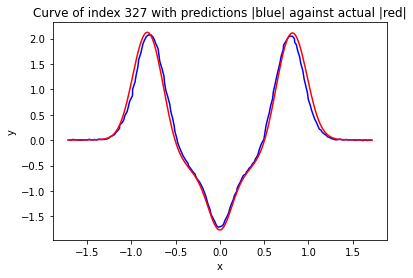

The loss of the curve 0.06625790043421415


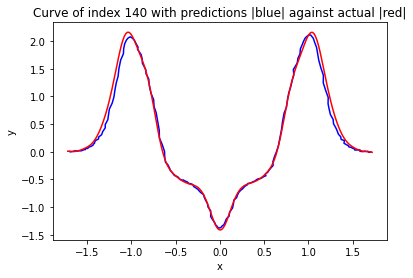

The loss of the curve 0.0449492063776019


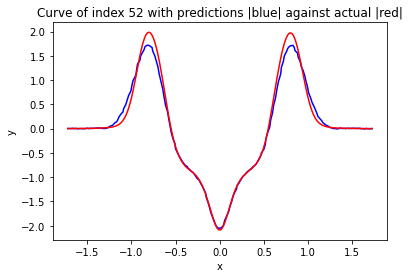

The loss of the curve 0.0728123891545134



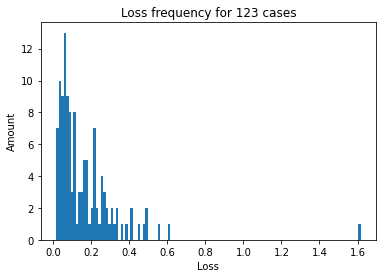

Loss average is: 0.16695468514044592
Loss mode is: [(0.23219, 1), (0.61236, 1), (0.41353, 1), (0.14625, 1), (0.2652, 1), (0.08267, 1), (0.03736, 1), (1.61554, 1), (0.1565, 1), (0.09762, 1)]
Loss median is: 0.10954
Loss 80th quantile: 0.25538098486757355
Loss 95th quantile: 0.44556213880988477


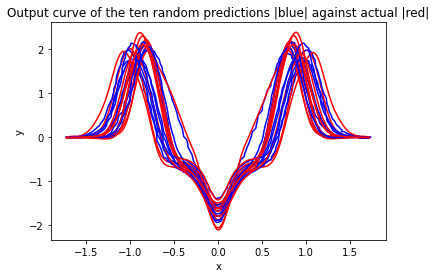

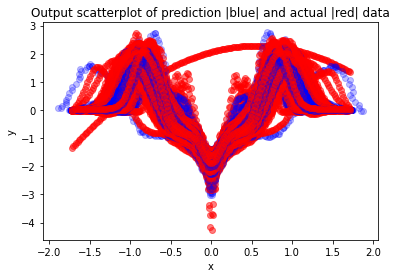

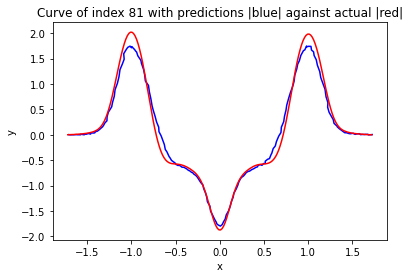

The loss of the curve 0.09319311172183718


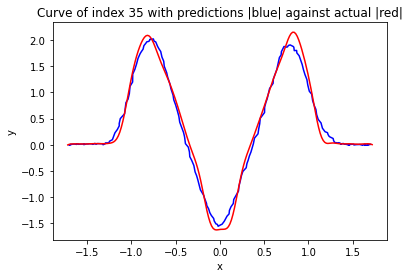

The loss of the curve 0.10889851357638912


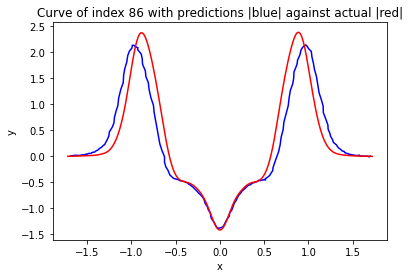

The loss of the curve 0.2771795533195167


In [30]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

optimizer = Adam(amsgrad=True, learning_rate = 0.001)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = optimizer, loss='mean_absolute_error')
# Notice we changed batch_size to 300
history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Based on these results we conclude that Adam optimizer will not provide better results as the MVP model, which is why will change it to Adamax that was used by the MVP. 

Trial 254 Complete [00h 01m 39s]
val_loss: 0.1003916785120964

Best val_loss So Far: 0.09756062179803848
Total elapsed time: 00h 38m 41s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 2, 'dense_0_units': 3500, 'dropout_0': 0.1, 'learning_rate': 0.01, 'dense_1_units': 1500, 'dropout_1': 0.2, 'dense_2_units': 4000, 'dropout_2': 0.05, 'dense_3_units': 1000, 'dropout_3': 0.1, 'dense_4_units': 1500, 'dropout_4': 0.15000000000000002, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0230'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3500)              3503500   
_________________________________________________________________
dropout (Dropout)            (None, 3500)              0         
_________________________________________________________________
dense_1 (Dense)              (None

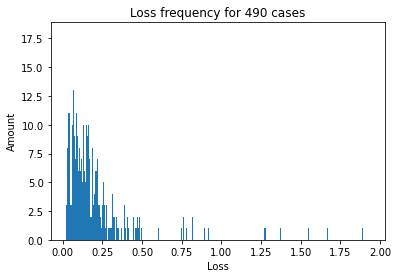

Loss average is: 0.1972236697166976
Loss mode is: [(0.03834, 2), (0.10486, 2), (0.24136, 2), (0.19396, 1), (0.06349, 1), (0.2939, 1), (0.06899, 1), (0.0349, 1), (0.17864, 1), (0.06901, 1)]
Loss median is: 0.139285
Loss 80th quantile: 0.2445900381574637
Loss 95th quantile: 0.4923330286095958


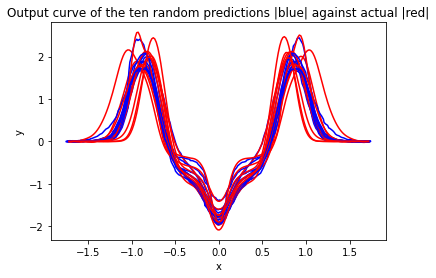

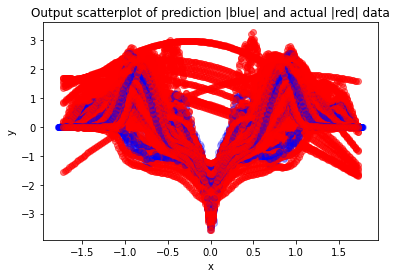

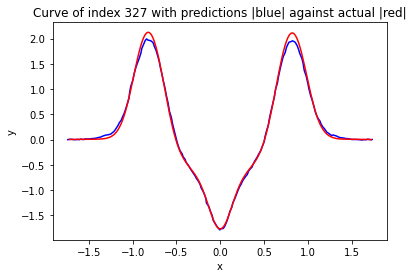

The loss of the curve 0.04178250385440806


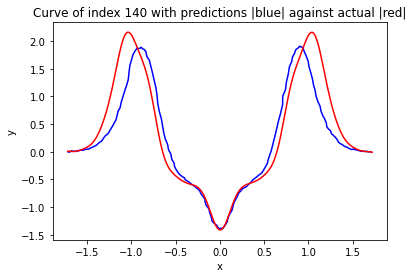

The loss of the curve 0.2568278933693981


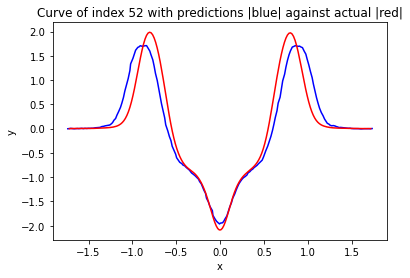

The loss of the curve 0.2092850167399987

Test data score


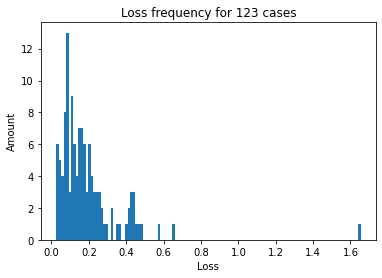

Loss average is: 0.19209107071332152
Loss mode is: [(0.16703, 1), (0.5744, 1), (0.41167, 1), (0.19865, 1), (0.44361, 1), (0.02633, 1), (0.17602, 1), (1.65394, 1), (0.25769, 1), (0.07023, 1)]
Loss median is: 0.15094
Loss 80th quantile: 0.2587984854095048
Loss 95th quantile: 0.4430778439448934


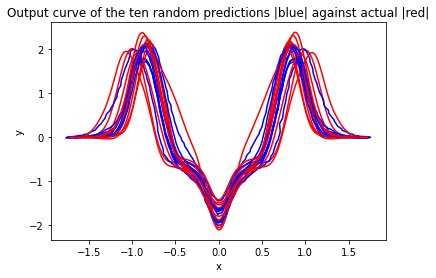

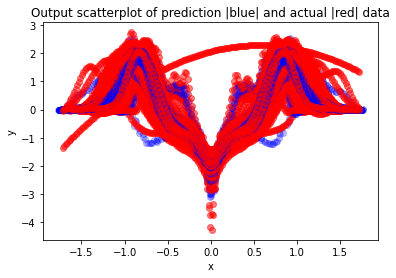

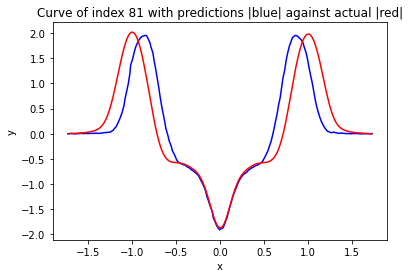

The loss of the curve 0.34585375866030943


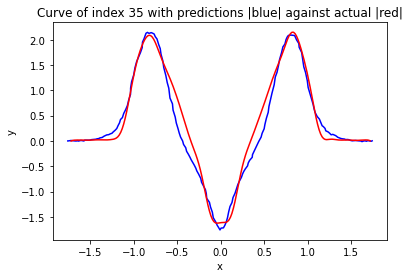

The loss of the curve 0.14629160116981335


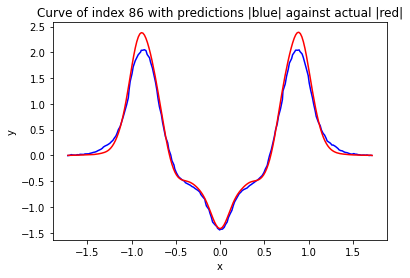

The loss of the curve 0.08463488100893996


In [31]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=4000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    # Notice that Adam is changed to Adamax
    model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),loss='mean_absolute_error')
    
    return model
# Notice that max_epochs is increased to 100
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 100,
    factor = 3,
    directory='my_dir',
    project_name='FF_to_TD_19')
# Notice that epochs is icnreased to 300
tuner.search(train_input, 
             train_output,
             epochs = 300,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_models = tuner.get_best_models(num_models=1)
print(best_models[0].summary())

print('')
print('Training data score')

results = metrics(train_output, best_model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output, best_model.predict(train_input))

print('')
print('Test data score')

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output, best_model.predict(test_input))

Used time: 181.55538082122803 seconds



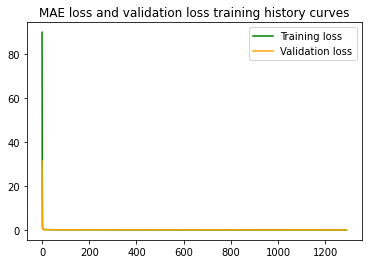


Training data score


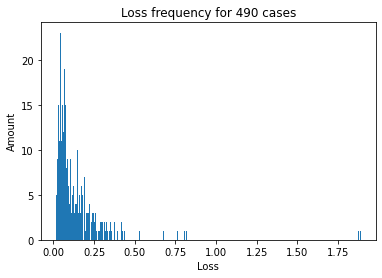

Loss average is: 0.14613000524621272
Loss mode is: [(0.05332, 2), (0.04331, 2), (0.06328, 2), (0.07244, 2), (0.04631, 2), (0.04604, 2), (0.08188, 2), (0.04607, 1), (0.12098, 1), (0.25512, 1)]
Loss median is: 0.08258499999999999
Loss 80th quantile: 0.1916543795306403
Loss 95th quantile: 0.39376766153408277


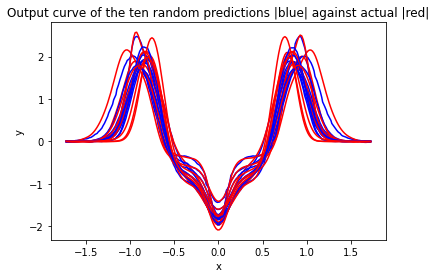

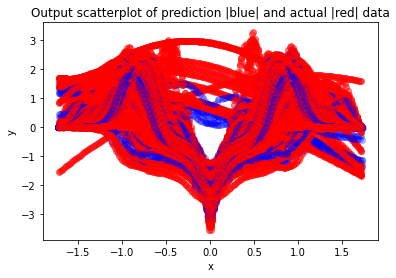

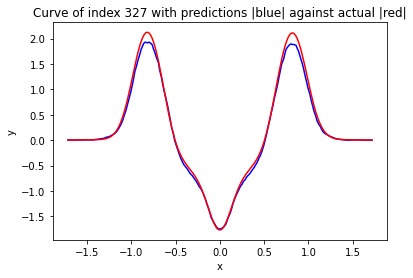

The loss of the curve 0.05582180239195763


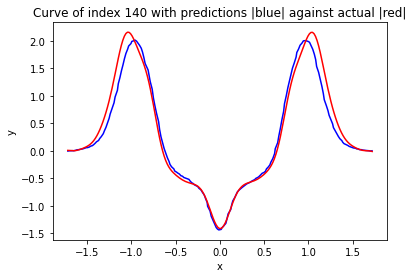

The loss of the curve 0.12286803428009005


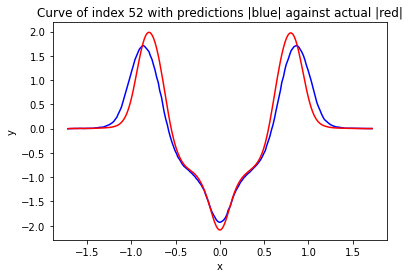

The loss of the curve 0.1696075013547446



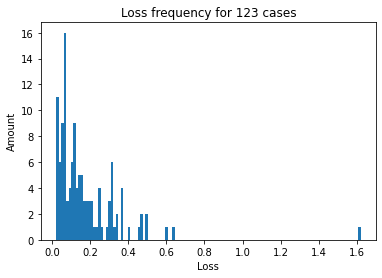

Loss average is: 0.17581314692439934
Loss mode is: [(0.19185, 1), (0.6051, 1), (0.36003, 1), (0.17773, 1), (0.26141, 1), (0.12584, 1), (0.08365, 1), (1.61973, 1), (0.33814, 1), (0.06785, 1)]
Loss median is: 0.12253
Loss 80th quantile: 0.292949417667578
Loss 95th quantile: 0.464492763381171


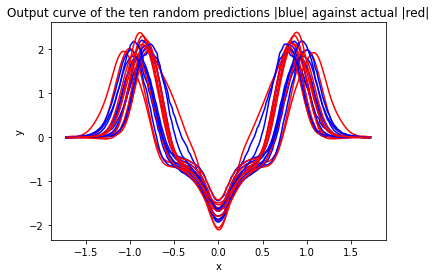

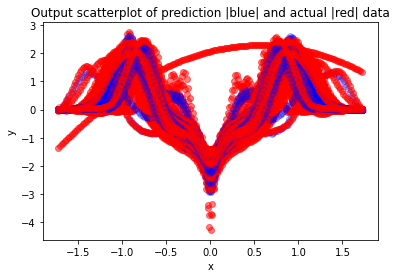

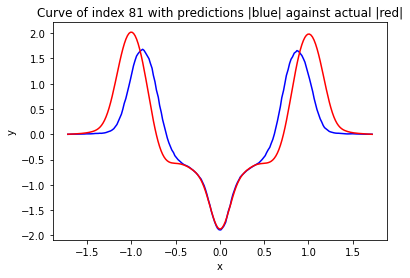

The loss of the curve 0.32124834391122725


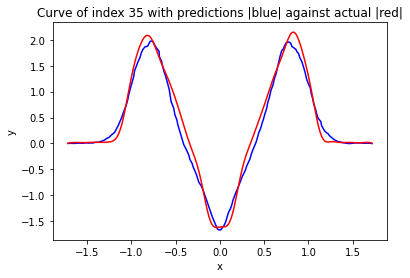

The loss of the curve 0.12486033940797318


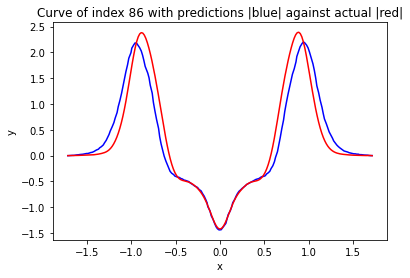

The loss of the curve 0.21410720207223993


In [32]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 132.87568593025208 seconds



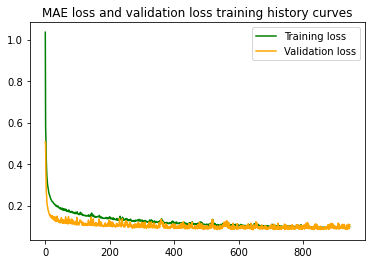


Training data score


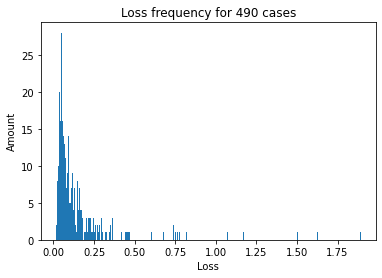

Loss average is: 0.1454270965875651
Loss mode is: [(0.04489, 2), (0.04611, 2), (0.07652, 2), (0.04631, 2), (0.06087, 2), (0.05917, 2), (0.04644, 2), (0.09247, 2), (0.08538, 1), (0.08379, 1)]
Loss median is: 0.08151
Loss 80th quantile: 0.1748002765472189
Loss 95th quantile: 0.44844173956075756


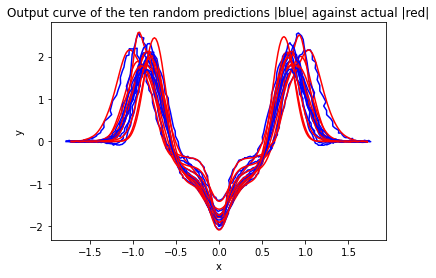

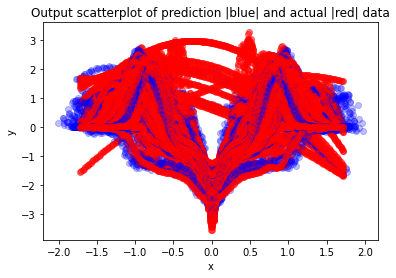

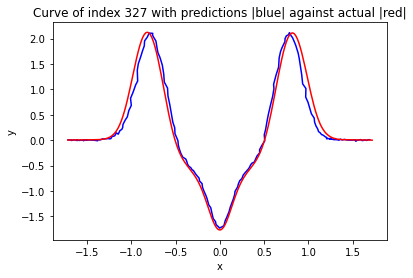

The loss of the curve 0.08511553582186311


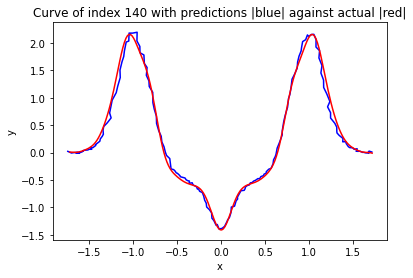

The loss of the curve 0.06305059538758746


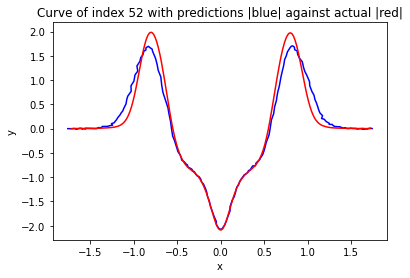

The loss of the curve 0.10736353416661293



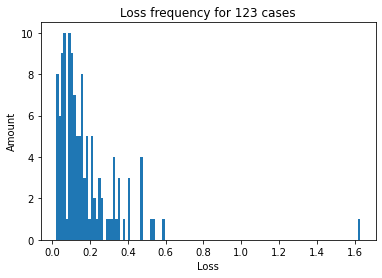

Loss average is: 0.1789688169871334
Loss mode is: [(0.16713, 1), (0.58771, 1), (0.35796, 1), (0.20945, 1), (0.18926, 1), (0.11802, 1), (0.05703, 1), (1.63089, 1), (0.16321, 1), (0.13358, 1)]
Loss median is: 0.12814
Loss 80th quantile: 0.2542352919594071
Loss 95th quantile: 0.4735951420559638


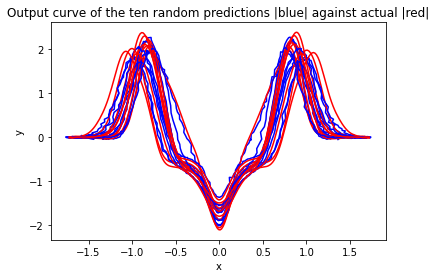

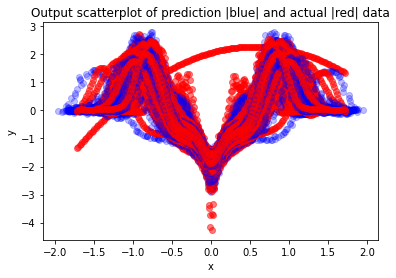

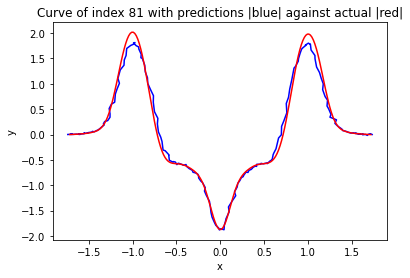

The loss of the curve 0.09803065454812476


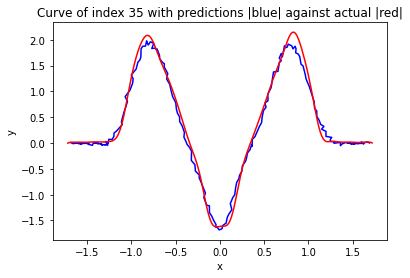

The loss of the curve 0.10734151298609658


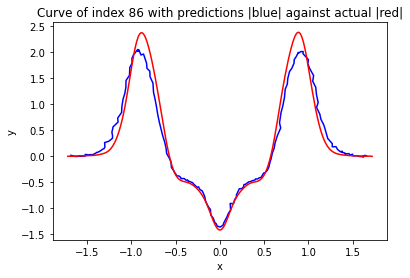

The loss of the curve 0.20738933145053412


In [33]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 411.7232735157013 seconds



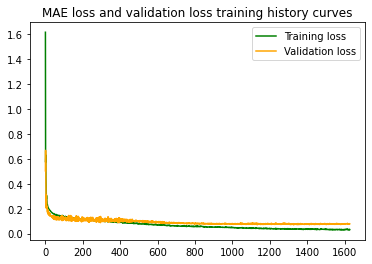


Training data score


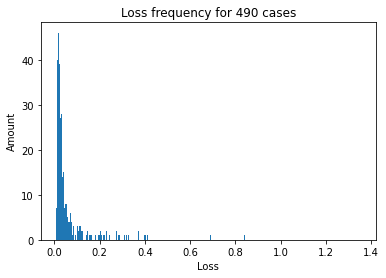

Loss average is: 0.06656363515958166
Loss mode is: [(0.03058, 3), (0.01979, 3), (0.0225, 3), (0.01927, 3), (0.03876, 3), (0.02425, 3), (0.01408, 2), (0.0258, 2), (0.01547, 2), (0.02317, 2)]
Loss median is: 0.029339999999999998
Loss 80th quantile: 0.07281377629089811
Loss 95th quantile: 0.25231570840495254


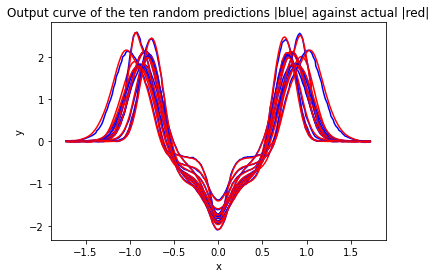

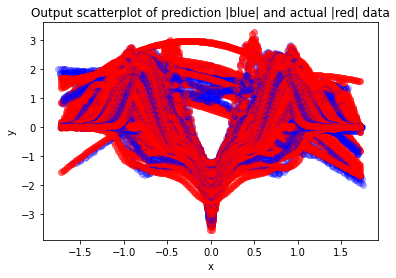

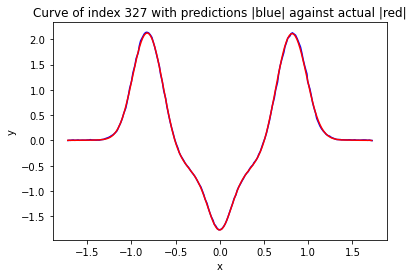

The loss of the curve 0.010823675795495447


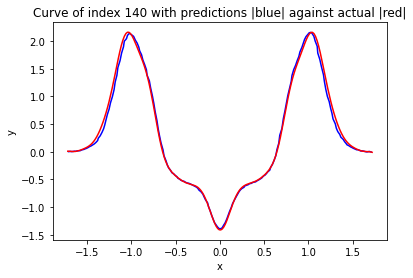

The loss of the curve 0.04072969279756181


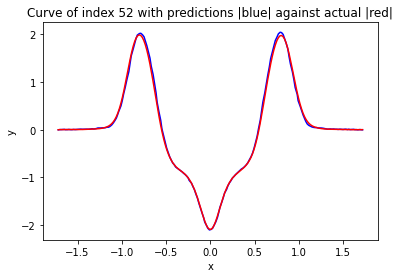

The loss of the curve 0.030046909783206913



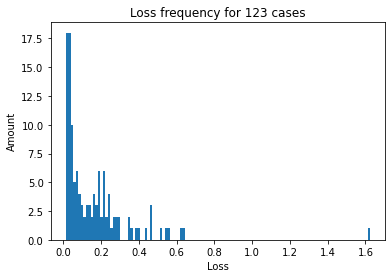

Loss average is: 0.1596085898945465
Loss mode is: [(0.11889, 1), (0.55408, 1), (0.07984, 1), (0.17418, 1), (0.51618, 1), (0.03282, 1), (0.29296, 1), (1.62532, 1), (0.09578, 1), (0.08371, 1)]
Loss median is: 0.09396
Loss 80th quantile: 0.2377783893190204
Loss 95th quantile: 0.4674134697030404


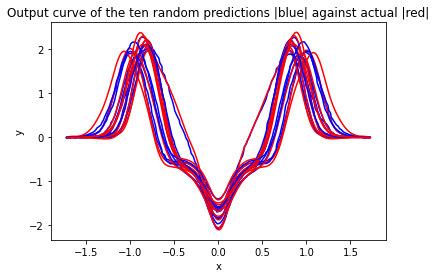

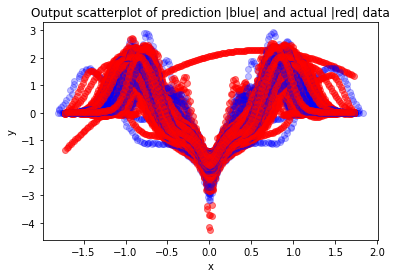

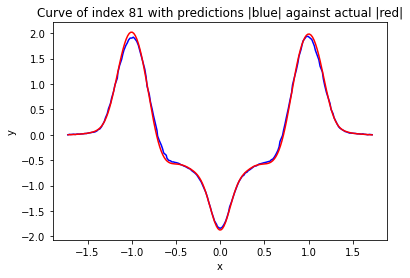

The loss of the curve 0.034739388312134696


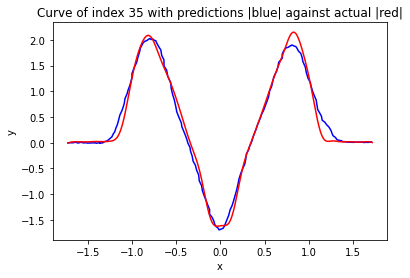

The loss of the curve 0.09395503253632143


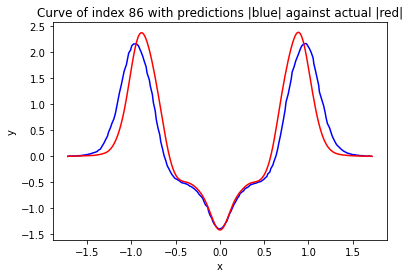

The loss of the curve 0.23877973953121082


In [34]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 362.76521253585815 seconds



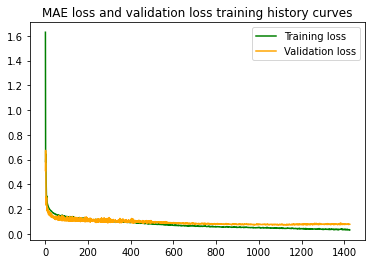


Training data score


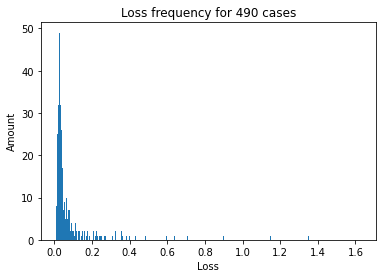

Loss average is: 0.08003240126277397
Loss mode is: [(0.02699, 2), (0.02119, 2), (0.02937, 2), (0.02479, 2), (0.02788, 2), (0.01499, 2), (0.026, 2), (0.02772, 2), (0.03348, 2), (0.03265, 2)]
Loss median is: 0.034034999999999996
Loss 80th quantile: 0.08203284207681927
Loss 95th quantile: 0.2821949514661578


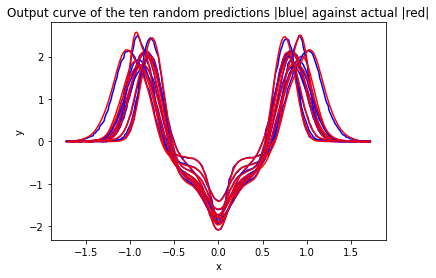

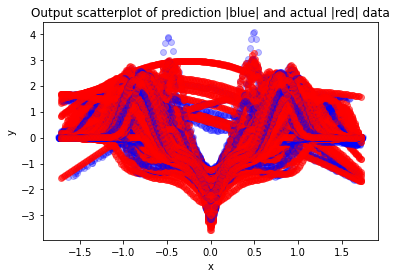

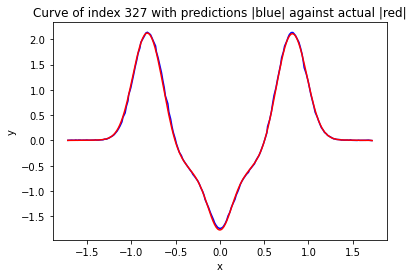

The loss of the curve 0.014033729013373599


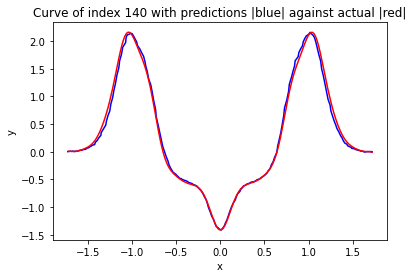

The loss of the curve 0.05792209183586907


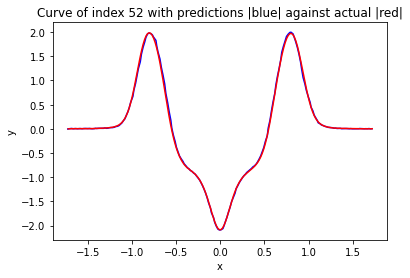

The loss of the curve 0.018756601243416802



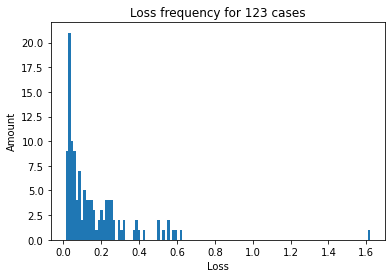

Loss average is: 0.16491468294578845
Loss mode is: [(0.11092, 1), (0.55927, 1), (0.09113, 1), (0.29505, 1), (0.59451, 1), (0.02259, 1), (0.29116, 1), (1.62024, 1), (0.12852, 1), (0.07038, 1)]
Loss median is: 0.10458
Loss 80th quantile: 0.2499730165624273
Loss 95th quantile: 0.5224692849420335


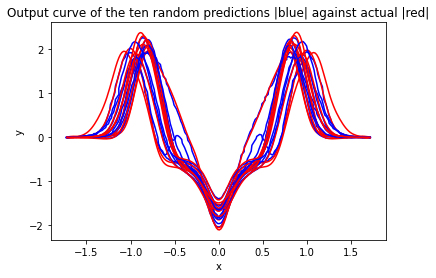

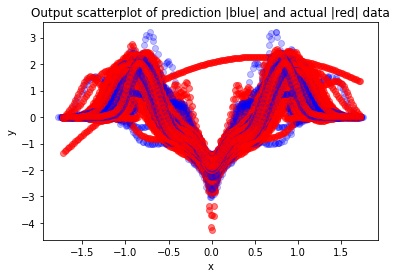

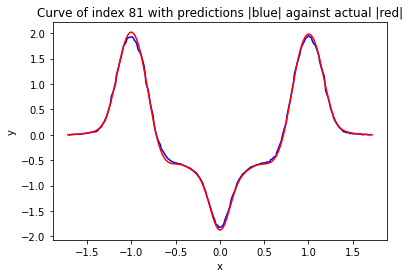

The loss of the curve 0.04287307434365224


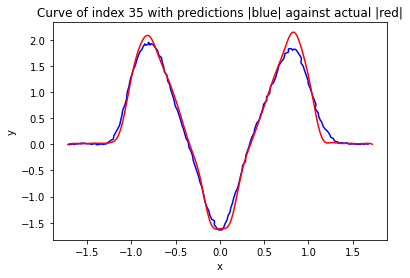

The loss of the curve 0.10457729270857395


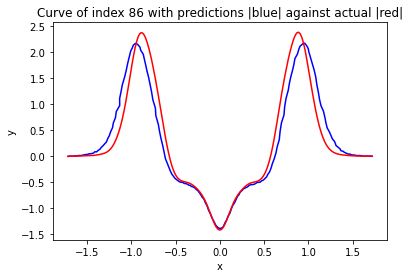

The loss of the curve 0.20742750105137034


In [6]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 504.6977548599243 seconds



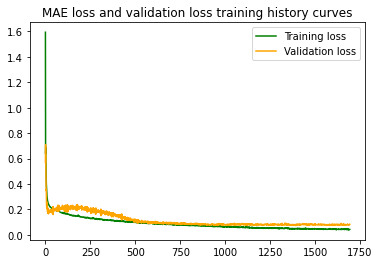


Training data score


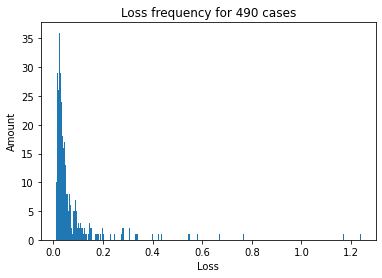

Loss average is: 0.07358025575711187
Loss mode is: [(0.01676, 3), (0.02444, 2), (0.01552, 2), (0.02533, 2), (0.02579, 2), (0.02651, 2), (0.03127, 2), (0.0294, 2), (0.02428, 2), (0.0187, 2)]
Loss median is: 0.038290000000000005
Loss 80th quantile: 0.08723973790543478
Loss 95th quantile: 0.2623766239971914


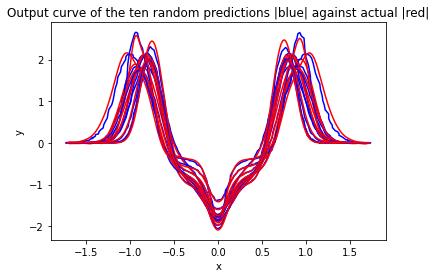

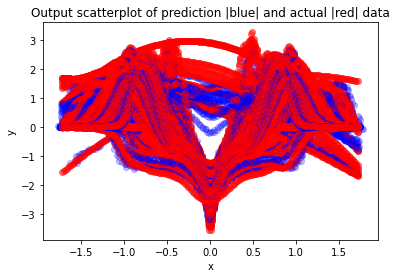

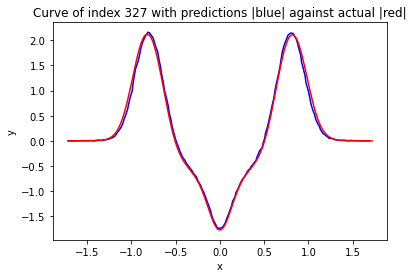

The loss of the curve 0.027992043168039174


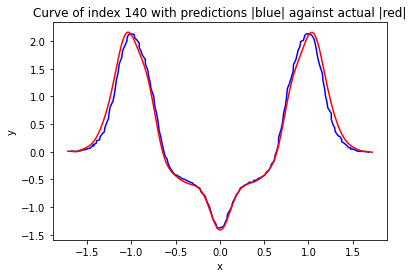

The loss of the curve 0.04268889159739019


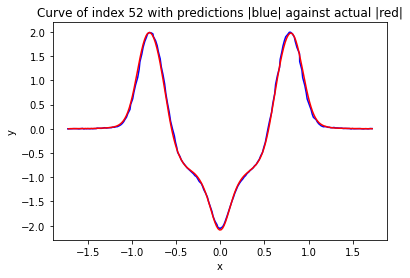

The loss of the curve 0.024123678162461738



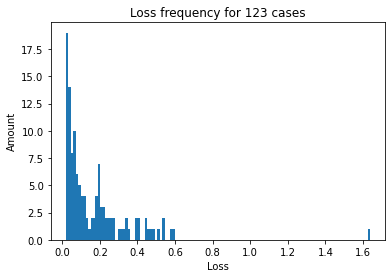

Loss average is: 0.16794480976002676
Loss mode is: [(0.05407, 2), (0.16576, 1), (0.53629, 1), (0.06713, 1), (0.20279, 1), (0.44294, 1), (0.02588, 1), (0.2701, 1), (1.63811, 1), (0.19057, 1)]
Loss median is: 0.09503
Loss 80th quantile: 0.2539934377655854
Loss 95th quantile: 0.4891581136626196


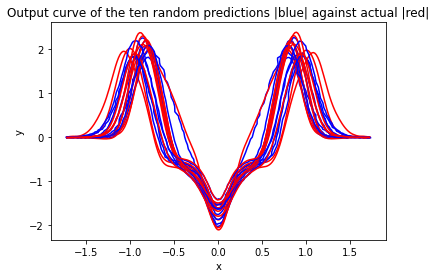

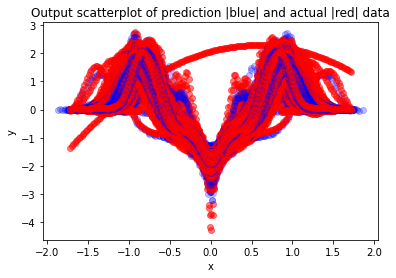

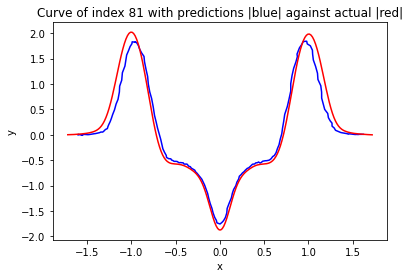

The loss of the curve 0.10020909594488919


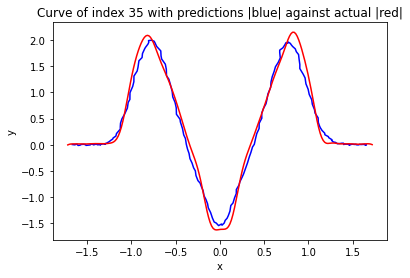

The loss of the curve 0.1187755574879849


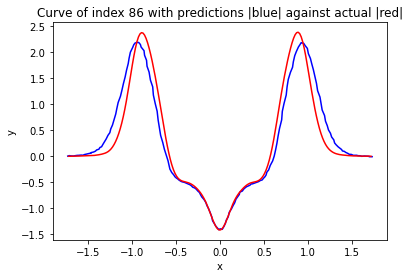

The loss of the curve 0.19706711313812153


In [7]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 368.8794729709625 seconds



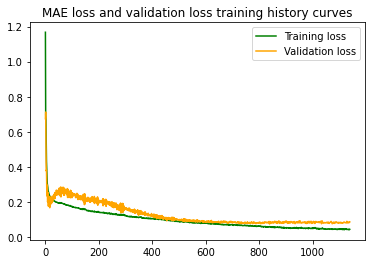


Training data score


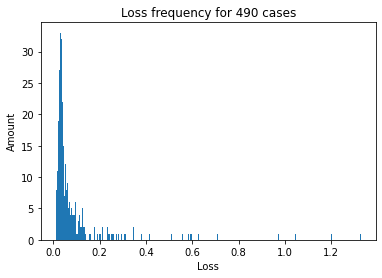

Loss average is: 0.08487501535683648
Loss mode is: [(0.03235, 2), (0.03658, 2), (0.03425, 2), (0.02817, 2), (0.029, 2), (0.03105, 2), (0.03676, 2), (0.0333, 2), (0.03448, 2), (0.03433, 2)]
Loss median is: 0.044175
Loss 80th quantile: 0.09247914985851965
Loss 95th quantile: 0.2700125743591792


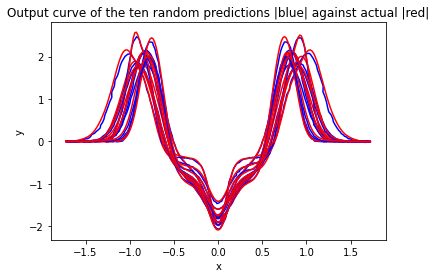

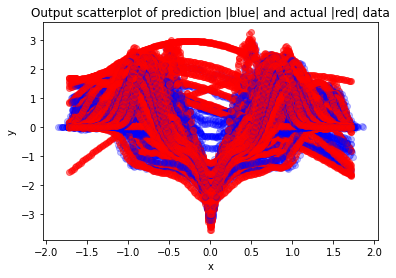

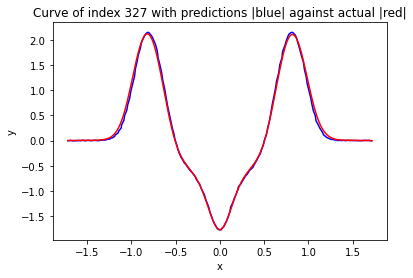

The loss of the curve 0.026530227447175106


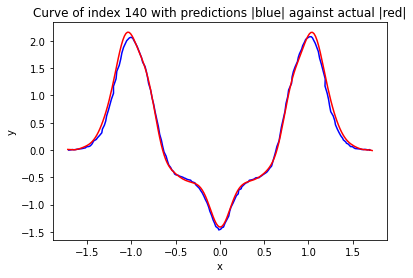

The loss of the curve 0.0430751225612534


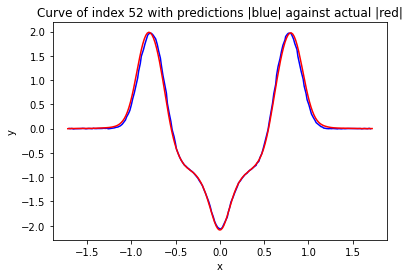

The loss of the curve 0.031050886281985143



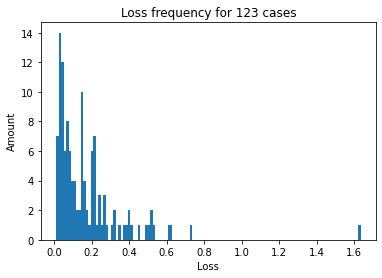

Loss average is: 0.1743631366777303
Loss mode is: [(0.03853, 2), (0.16387, 1), (0.50866, 1), (0.08358, 1), (0.20917, 1), (0.61338, 1), (0.01917, 1), (0.21741, 1), (1.6336, 1), (0.14387, 1)]
Loss median is: 0.11703
Loss 80th quantile: 0.24277147080935485
Loss 95th quantile: 0.5155157956269252


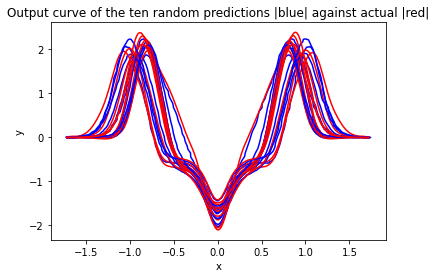

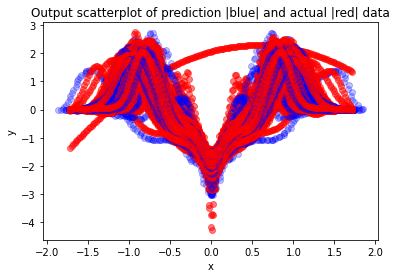

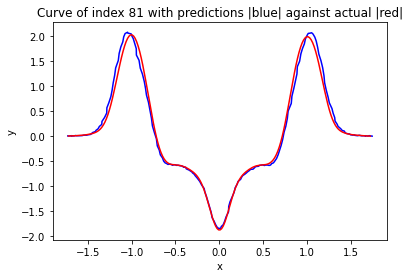

The loss of the curve 0.06014738084866961


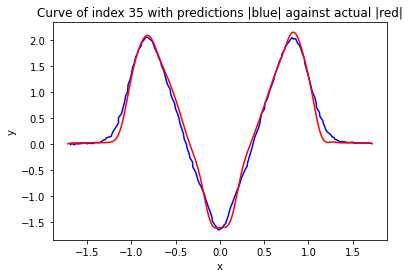

The loss of the curve 0.11703425032863542


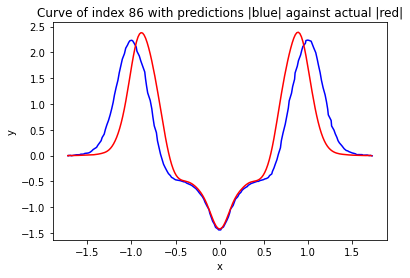

The loss of the curve 0.3441213362327623


In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')
print('Test data score')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 113.05491638183594 seconds



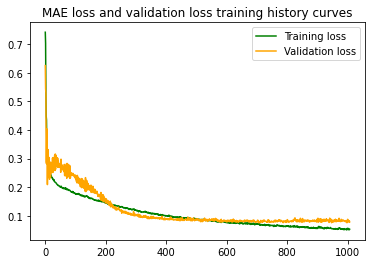


Training data score


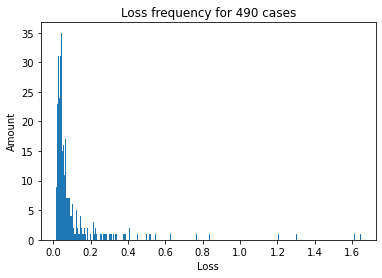

Loss average is: 0.10019463429665548
Loss mode is: [(0.04393, 2), (0.02294, 2), (0.04367, 2), (0.04086, 2), (0.02409, 2), (0.06735, 2), (0.02733, 2), (0.02864, 2), (0.03568, 2), (0.04309, 2)]
Loss median is: 0.04803
Loss 80th quantile: 0.10483367388919572
Loss 95th quantile: 0.3373345916932181


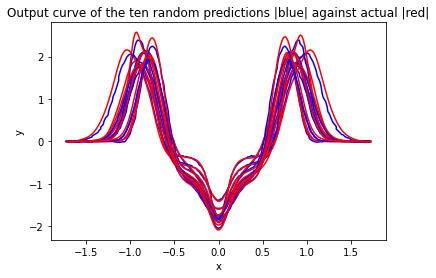

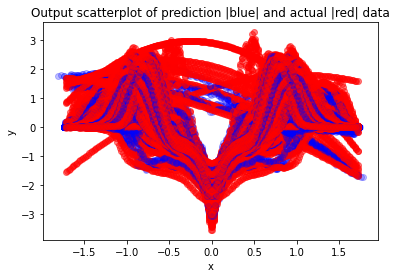

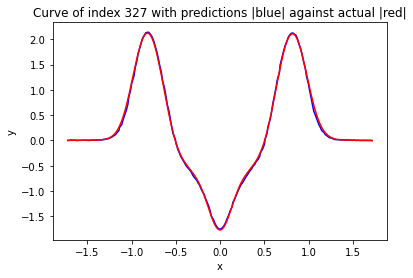

The loss of the curve 0.024749093200628694


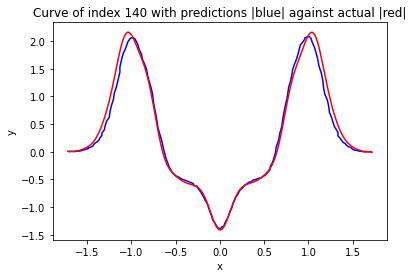

The loss of the curve 0.0655094485901638


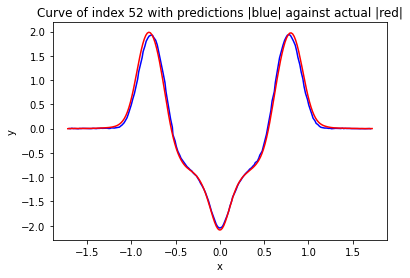

The loss of the curve 0.04193393792382838

Test data score


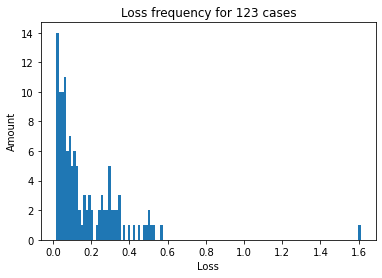

Loss average is: 0.1700422174066149
Loss mode is: [(0.18278, 1), (0.51504, 1), (0.08736, 1), (0.20825, 1), (0.35002, 1), (0.0534, 1), (0.2673, 1), (1.61021, 1), (0.0837, 1), (0.0909, 1)]
Loss median is: 0.10275
Loss 80th quantile: 0.29371732128869
Loss 95th quantile: 0.4924053270949145


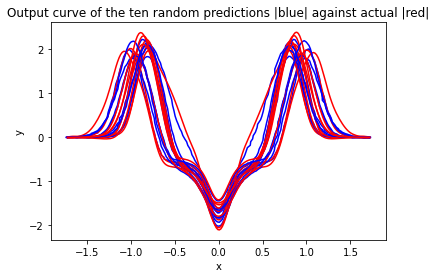

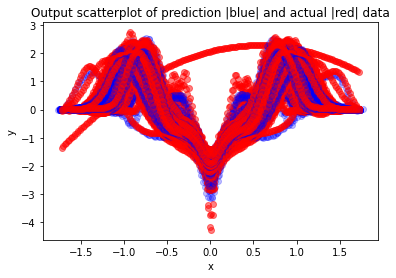

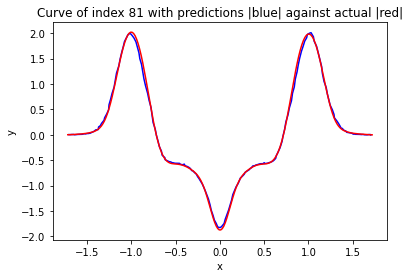

The loss of the curve 0.038413752416980015


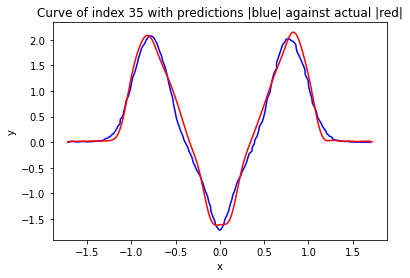

The loss of the curve 0.11344559035603474


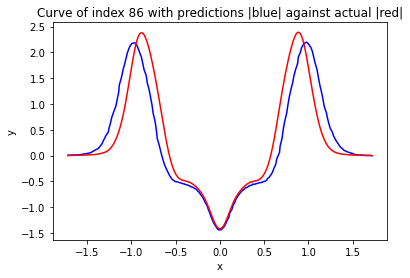

The loss of the curve 0.3063642023388646


In [6]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')
print('Test data score')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 425.3045918941498 seconds



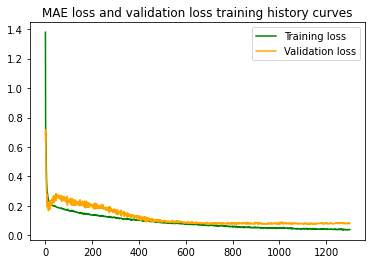


Training data score


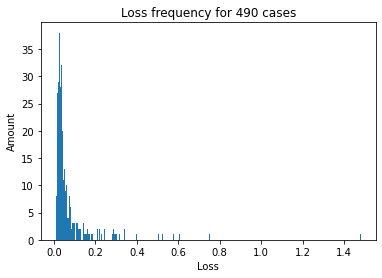

Loss average is: 0.07627731975478425
Loss mode is: [(0.02843, 2), (0.02526, 2), (0.03908, 2), (0.03376, 2), (0.03002, 2), (0.03639, 2), (0.04072, 2), (0.02346, 2), (0.08184, 2), (0.03721, 2)]
Loss median is: 0.03833
Loss 80th quantile: 0.08165368854072856
Loss 95th quantile: 0.2762626197637942


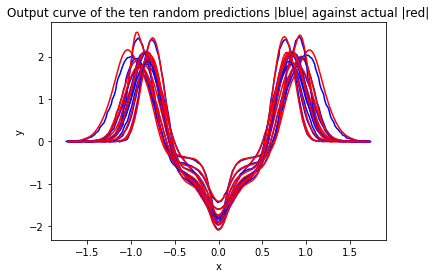

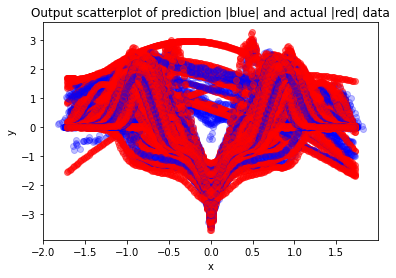

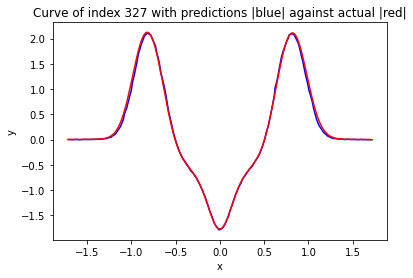

The loss of the curve 0.020580887570918253


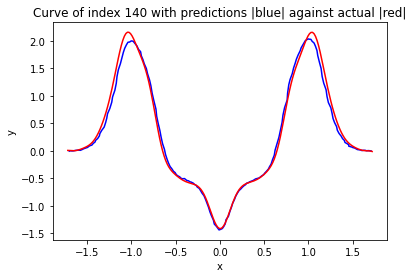

The loss of the curve 0.0615172173176541


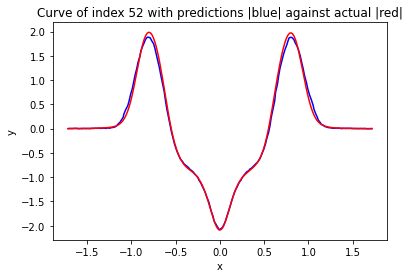

The loss of the curve 0.038593991743491644



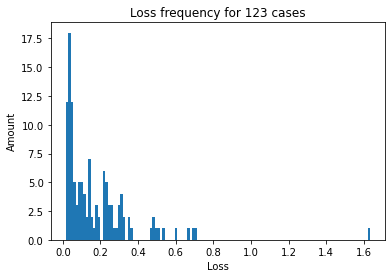

Loss average is: 0.17695777970546123
Loss mode is: [(0.15064, 1), (0.59583, 1), (0.15254, 1), (0.21647, 1), (0.46576, 1), (0.03408, 1), (0.31736, 1), (1.63339, 1), (0.22116, 1), (0.12063, 1)]
Loss median is: 0.11232
Loss 80th quantile: 0.26502715194666926
Loss 95th quantile: 0.5123160623674727


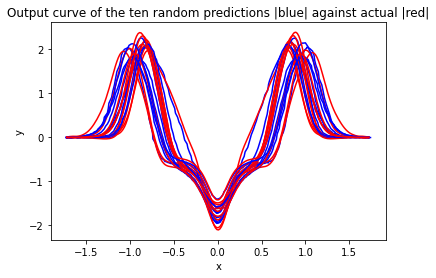

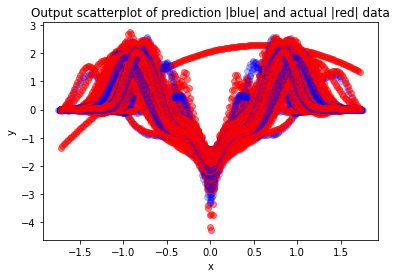

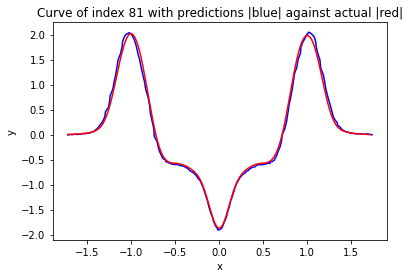

The loss of the curve 0.027459718187927064


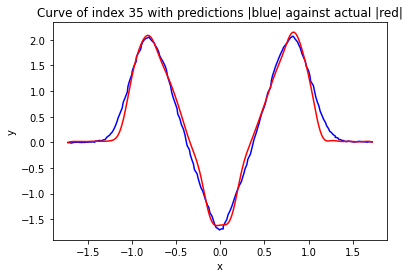

The loss of the curve 0.09884993034355949


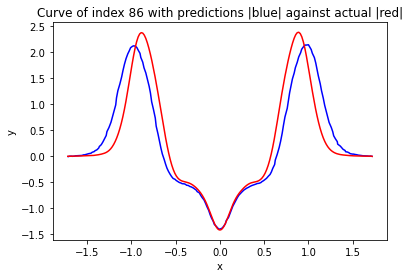

The loss of the curve 0.28632905133341935


In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 355.18159675598145 seconds



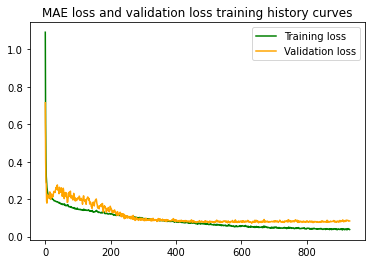


Training data score


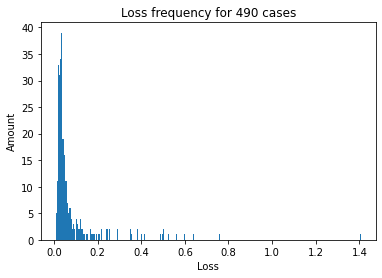

Loss average is: 0.07682349591451104
Loss mode is: [(0.02233, 4), (0.02431, 2), (0.03163, 2), (0.03457, 2), (0.02749, 2), (0.043, 2), (0.01933, 2), (0.04347, 2), (0.02756, 2), (0.03166, 2)]
Loss median is: 0.03746
Loss 80th quantile: 0.08178731180332101
Loss 95th quantile: 0.2881919177432191


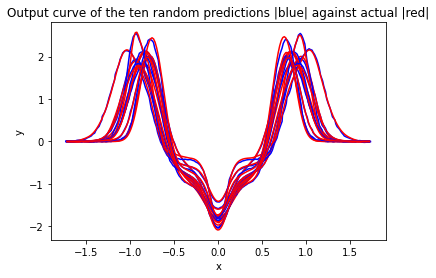

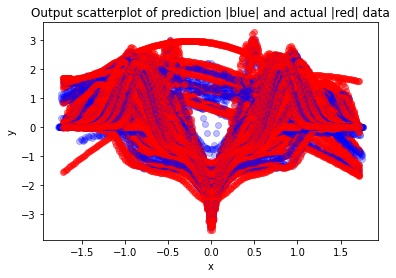

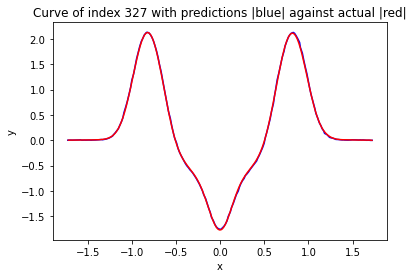

The loss of the curve 0.014552499790825648


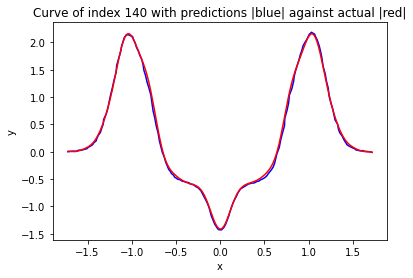

The loss of the curve 0.026144911605364144


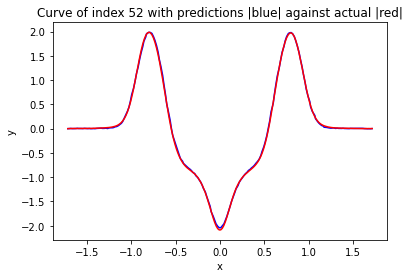

The loss of the curve 0.019325267091680268



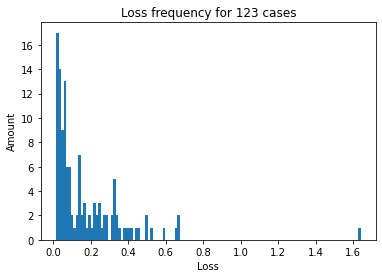

Loss average is: 0.17045167634443822
Loss mode is: [(0.06006, 2), (0.05882, 2), (0.19858, 1), (0.59561, 1), (0.13349, 1), (0.21846, 1), (0.46011, 1), (0.02257, 1), (0.05136, 1), (1.63926, 1)]
Loss median is: 0.0886
Loss 80th quantile: 0.28818595060421975
Loss 95th quantile: 0.5016466185263841


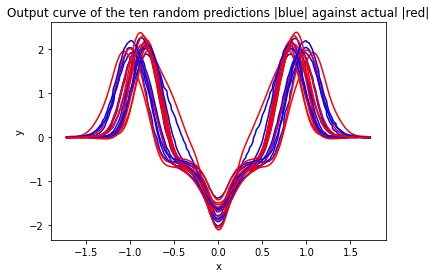

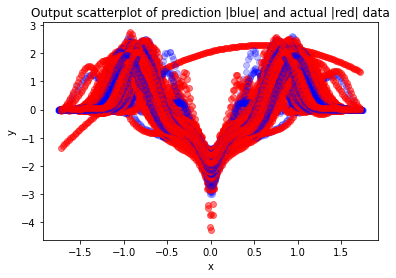

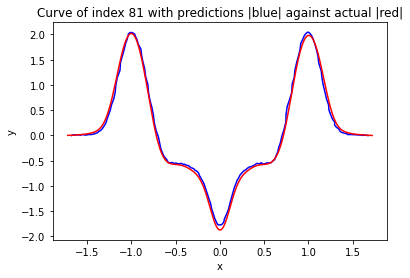

The loss of the curve 0.058819339466565965


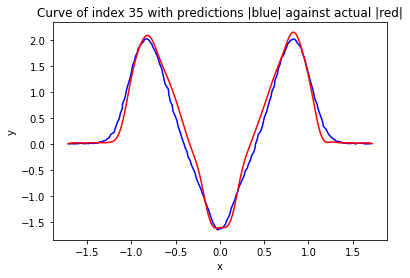

The loss of the curve 0.13694277214413111


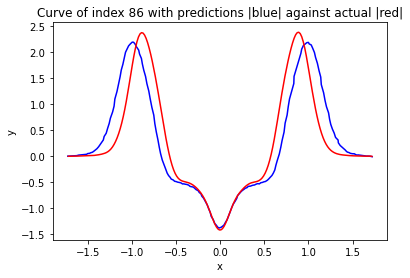

The loss of the curve 0.3239714992081319


In [9]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=100, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 353.4712564945221 seconds



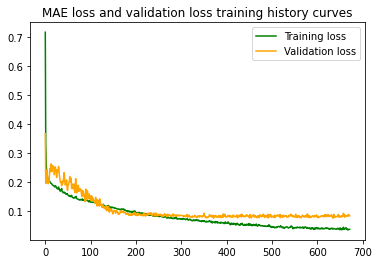


Training data score


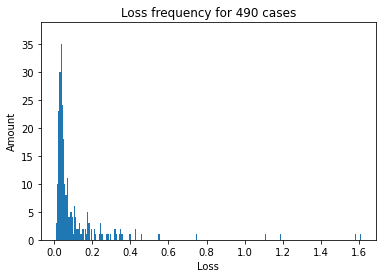

Loss average is: 0.09884010699883561
Loss mode is: [(0.03578, 2), (0.04777, 2), (0.03225, 2), (0.02984, 2), (0.04437, 2), (0.02227, 2), (0.04446, 2), (0.03917, 2), (0.03983, 2), (0.02629, 1)]
Loss median is: 0.04632
Loss 80th quantile: 0.10836155157936044
Loss 95th quantile: 0.34557261899347747


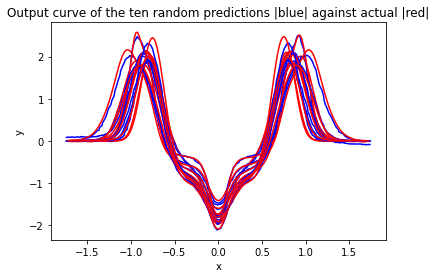

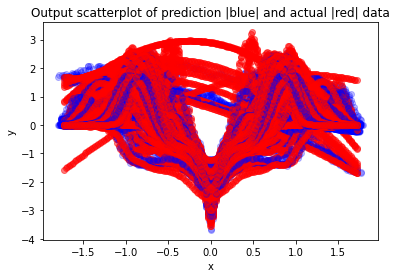

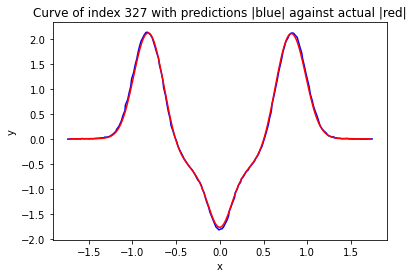

The loss of the curve 0.017699043340532485


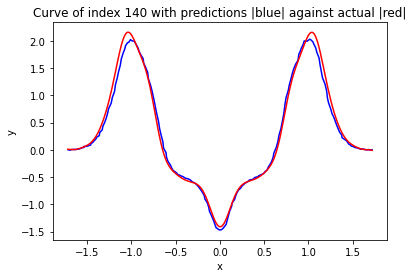

The loss of the curve 0.07249880559451612


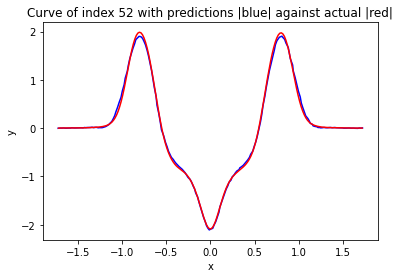

The loss of the curve 0.02676685407974398



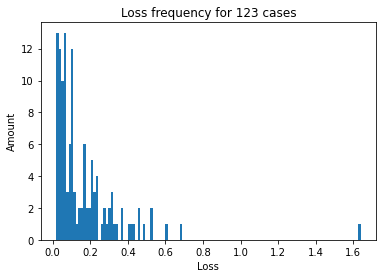

Loss average is: 0.1661751509925168
Loss mode is: [(0.19479, 1), (0.60299, 1), (0.09238, 1), (0.23282, 1), (0.46432, 1), (0.0474, 1), (0.14007, 1), (1.63824, 1), (0.22083, 1), (0.10625, 1)]
Loss median is: 0.10552
Loss 80th quantile: 0.24010905843730862
Loss 95th quantile: 0.4639317882735341


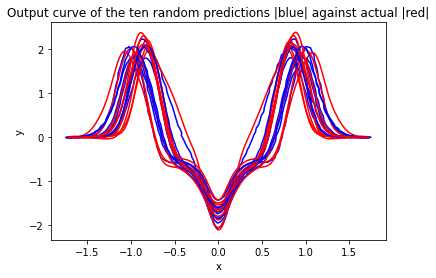

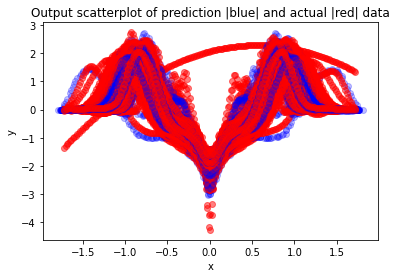

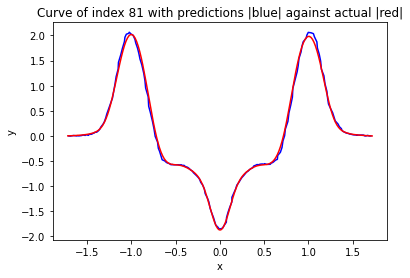

The loss of the curve 0.05977855863102059


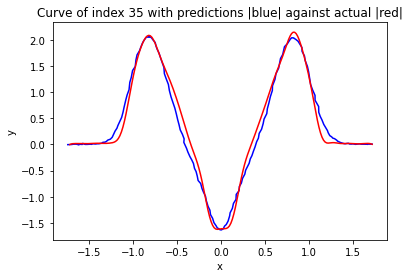

The loss of the curve 0.10821706330045569


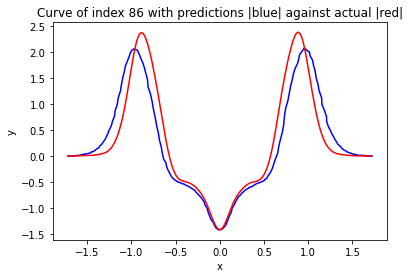

The loss of the curve 0.275177734804452


In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=50, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Used time: 436.15208864212036 seconds



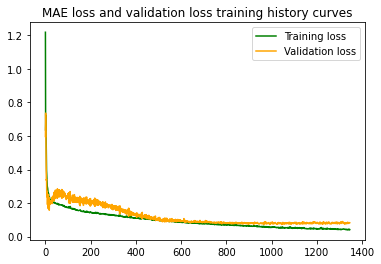


Training data score


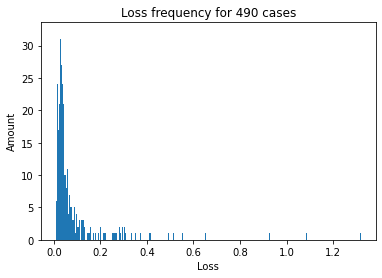

Loss average is: 0.08480995885789364
Loss mode is: [(0.1132, 2), (0.02849, 2), (0.0327, 2), (0.03949, 2), (0.02072, 2), (0.02817, 2), (0.04702, 2), (0.03279, 2), (0.05894, 2), (0.03169, 2)]
Loss median is: 0.040605
Loss 80th quantile: 0.09652704462665639
Loss 95th quantile: 0.2840843340035285


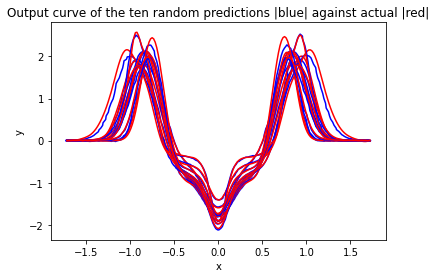

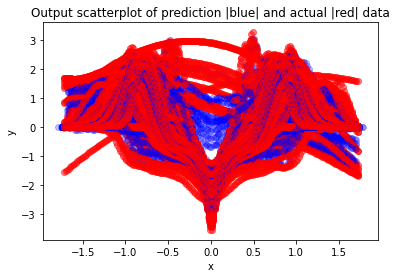

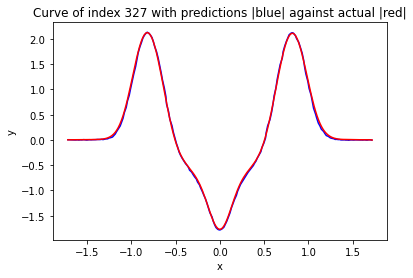

The loss of the curve 0.018332546692334216


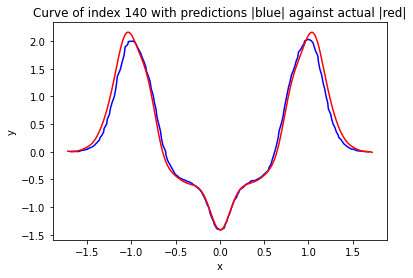

The loss of the curve 0.061652961151440804


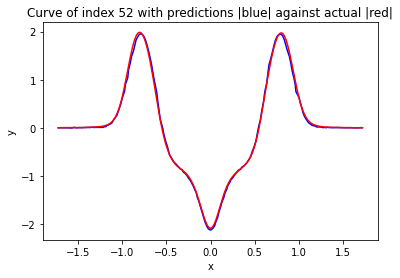

The loss of the curve 0.03175467683266698



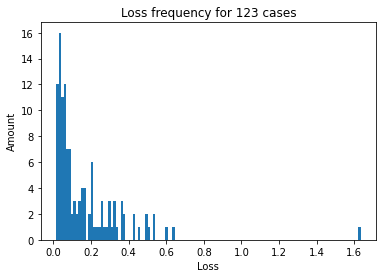

Loss average is: 0.16623845236446338
Loss mode is: [(0.15965, 1), (0.43492, 1), (0.07399, 1), (0.20172, 1), (0.49115, 1), (0.02563, 1), (0.21825, 1), (1.6334, 1), (0.12784, 1), (0.07717, 1)]
Loss median is: 0.08821
Loss 80th quantile: 0.27481431664662237
Loss 95th quantile: 0.4967583622727714


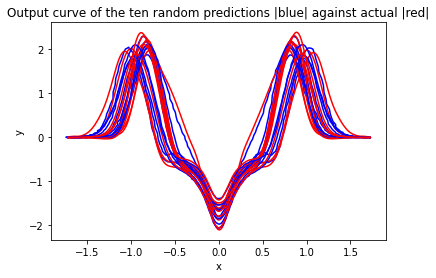

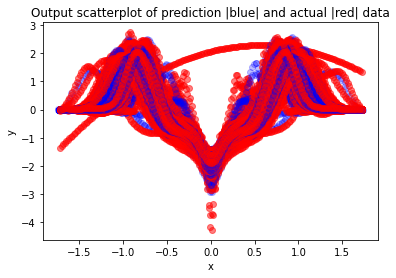

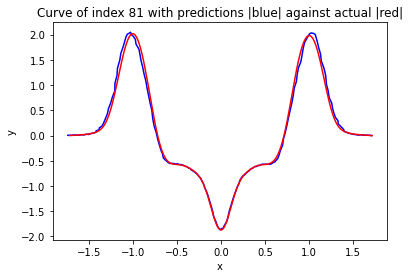

The loss of the curve 0.05595358733877503


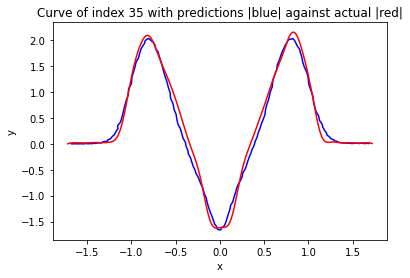

The loss of the curve 0.11903239188692931


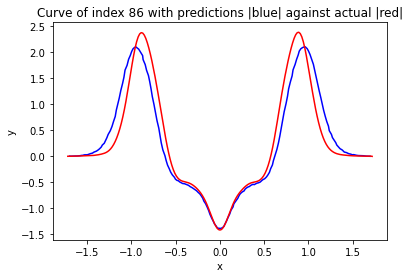

The loss of the curve 0.25312579213323305


In [11]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

print('')

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.title('MAE loss and validation loss training history curves')
plt.legend()
plt.show()

print('')
print('Training data score')

results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

print('')

results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

We have finally achieved a model, which has a slightly better performance than the MVP. The performance increase is mostly done in the loss median from 0.0978 to 0.0882 with performance decrease in 80th and 95th quantiles. These improvements are not impressive, which suggests that the average loss of 0.166 is the best possible score for this approach and data. Regardless, we are now happy about this improvement, so we save the this model by running the following code. The saved model can be run in the companion notebook or any other kind of setting using Keras.

In [12]:
model.save('Final_FF_to_TD.h5')